# **Pretrain Transformer-based Final Alpha Model**

## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

# Import preprocessor from sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Model Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# For ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Feature Selection and Feature Importance
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier

# Time series cross-validation
from sklearn.model_selection import TimeSeriesSplit

# Class encoder
from sklearn.preprocessing import LabelEncoder

# Models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

## Data Collection

We prepare our data from 2020/01/01 to 2023/12/31 and we will consider historical BTC data with 1h interval.

In [2]:
df = pd.read_csv("../data/final-alpha-model-data.csv", index_col=0, parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2020-01-01 17:00:00 to 2023-01-01 15:00:00
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   close                              26303 non-null  float64
 1   high                               26303 non-null  float64
 2   low                                26303 non-null  float64
 3   open                               26303 non-null  float64
 4   volume                             26303 non-null  float64
 5   log_returns                        26303 non-null  float64
 6   min_10k_count                      26303 non-null  int64  
 7   min_100_count                      26303 non-null  int64  
 8   new_non_zero_count                 26303 non-null  int64  
 9   count                              26303 non-null  int64  
 10  active_more_1y_percent             26303 non-null  float64
 11  block_count        

In [4]:
df.head(5)

,close,high,low,open,volume,log_returns,min_10k_count,min_100_count,new_non_zero_count,count,...,sopr,loss_sum,liveliness,nvt,nvts,reserve_risk,rhodl_ratio,stock_to_flow_deflection,utxo_created_count,velocity
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 17:00:00,7233.80,7248.00,7221.88,7241.91,2477.807,-0.001120,109,16209,20313,596079991,...,0.999051,7.523547e+06,0.607797,819.771295,716.378862,0.000041,611.396889,0.884971,38237,0.001220
2020-01-01 18:00:00,7237.47,7241.95,7222.00,7233.87,1827.668,0.000507,109,16215,14181,596094172,...,0.999407,7.586606e+06,0.607789,1154.776475,715.356827,0.000041,608.884855,0.883311,25450,0.000866
2020-01-01 19:00:00,7226.35,7237.83,7223.15,7237.83,1028.577,-0.001538,109,16217,13904,596108076,...,0.990449,7.579957e+06,0.607772,1287.454092,715.704908,0.000041,609.037200,0.883312,26933,0.000777
2020-01-01 20:00:00,7233.30,7242.00,7223.09,7226.56,1476.534,0.000961,109,16216,12454,596120530,...,0.998999,7.553311e+06,0.607765,1556.820359,716.438407,0.000041,609.027076,0.884052,26166,0.000642
2020-01-01 21:00:00,7229.71,7238.79,7225.00,7233.32,1210.884,-0.000496,109,16217,15011,596135541,...,0.999485,7.560363e+06,0.607757,978.046894,716.527949,0.000041,609.021778,0.883647,28188,0.001022


<Axes: xlabel='timestamp'>

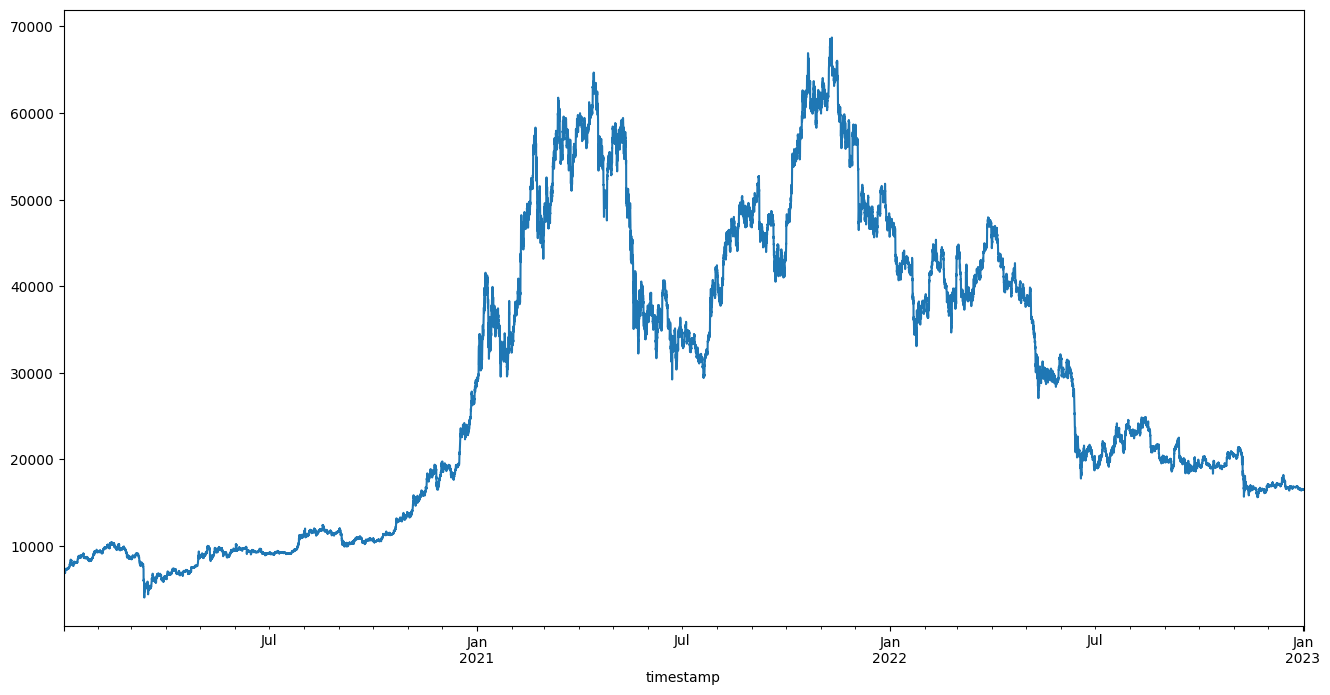

In [5]:
df["close"].plot(figsize=(16, 8))

## Technical Indicators

The table below summarizes the metrics we are including from technical analysis for bitcoin:
#### Table 1 – List of Technical Market Indicators </font>
<table>
<thead><tr>
<th style="text-align:left">Symbol</th>
<th style="text-align:left">Description</th>   
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">ATR</td>
<td style="text-align:left">The average true range (ATR) is a market volatility indicator used in technical analysis. </td>       
</tr>    
<tr>       
<td style="text-align:left">sma14, sma60</td>
<td style="text-align:left">A simple moving average is a technical indicator that can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.</td>       
</tr>        
<tr>    
<td style="text-align:left">vol14, vol60</td>
<td style="text-align:left">Volatility is used as a measure of a security's riskiness. Typically investors view a high volatility as high risk.</td>    
</tr>       
<tr>    
<td style="text-align:left">sma20,b_upper,b_lower</td>
<td style="text-align:left">Bollinger Bands are a technical analysis tool developed for generating oversold or overbought signals.The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average, but can be modified. </td>      
</tr>    
<tr>         
<td style="text-align:left">MOM5D</td>
<td style="text-align:left">the momentum of 5 days</td> 
</tr> 
</tbody>
</table>     

### Average True Range (ATR)

In [6]:
# Function to calculate average true range (ATR) 

def ATR(df,n):
    "function to calculate True Range and Average True Range"
    df = df.copy() 

    df['H-L'] = abs(df['high']-df['low'])
    df['H-PO'] = abs(df['high']-df['close'].shift(1))
    df['L-PO'] = abs(df['low']-df['close'].shift(1))
    
    df['TR'] = df[['H-L','H-PO','L-PO']].max(axis = 1,skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()

    df2 = df.drop(['H-L','H-PO','L-PO'],axis = 1)
    return df2

In [7]:
#ATR
ATR_Bitcoin = ATR(df,21)['ATR']
df['ATR'] = ATR_Bitcoin

### Classic Technical Indicators

In [8]:
# Classic Technnical Indicators
# Simple Moving Averages
# 2 week
df['sma14'] = df['close'].rolling(14).mean()
# 2 month
df['sma60'] = df['close'].rolling(60).mean()

# Rolling Volatility (annualized assuming 365 trading days)
# 2 week
df['vol14'] = df['log_returns'].rolling(14).std() * np.sqrt(365)
# 2 month
df['vol60'] = df['log_returns'].rolling(60).std() * np.sqrt(365)

In [9]:
# Bollinger Bands
 #20 day simple moving average
df['sma20'] = df['close'].rolling(20).mean()
# Upper band
df['b_upper'] = df['sma20'] + 2 * df['sma20'].rolling(20).std()
# Lower band
df['b_lower'] = df['sma20'] - 2 * df['sma20'].rolling(20).std()

In [10]:
# Momentum
MOM5D = np.around([df['close'][t] - df['close'][t-5] 
                   for t in range(5,len(df['close']))],3)

# For these features we have to reduce the sample size due to min{len(MOM5D),
# len(STD21D)}<len(Bitcoin)
N = len(MOM5D)
df = df[::- 1].iloc[range(0,N)] 
df = df[::- 1] 
df['MOM5D'] = MOM5D

C:\Users\BoonPing\AppData\Local\Temp\ipykernel_24400\3090866595.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MOM5D = np.around([df['close'][t] - df['close'][t-5]


In [11]:
# Check for null values
df.isnull().sum()

close                                 0
high                                  0
low                                   0
open                                  0
volume                                0
log_returns                           0
min_10k_count                         0
min_100_count                         0
new_non_zero_count                    0
count                                 0
active_more_1y_percent                0
block_count                           0
hash_rate_mean                        0
inflation_rate                        0
revenue_from_fees                     0
balance_exchanges                     0
transfers_volume_to_exchanges_sum     0
net_realized_profit_loss              0
net_unrealized_profit_loss            0
realized_loss                         0
realized_profit                       0
sopr                                  0
loss_sum                              0
liveliness                            0
nvt                                   0


In [12]:
df = df.dropna()

## Adding Lags

Lag 1: ACF = -0.0159, PACF = -0.0159
Lag 2: ACF = -0.0226, PACF = -0.0229
Lag 3: ACF = 0.0008, PACF = 0.0001
Lag 4: ACF = -0.0164, PACF = -0.0169
Lag 5: ACF = -0.0031, PACF = -0.0036
Lag 6: ACF = -0.0019, PACF = -0.0028
Lag 7: ACF = -0.0072, PACF = -0.0074
Lag 8: ACF = -0.0042, PACF = -0.0048
Lag 9: ACF = -0.0034, PACF = -0.0041
Lag 10: ACF = 0.0161, PACF = 0.0157


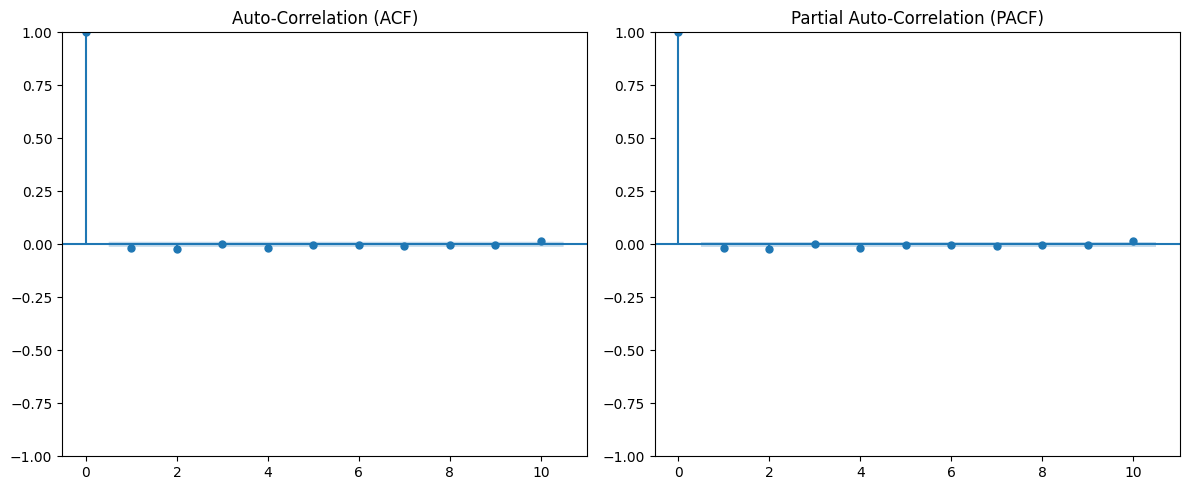

In [13]:
log_returns = df['log_returns'].dropna()

# Get values (adjust nlags as needed)
acf_values = acf(log_returns, nlags=10)
pacf_values = pacf(log_returns, nlags=10)

# Print them
for lag in range(1, len(acf_values)):
    print(f"Lag {lag}: ACF = {acf_values[lag]:.4f}, PACF = {pacf_values[lag]:.4f}")

#  Step 1: Plot ACF & PACF BEFORE adding lag features
plt.figure(figsize=(12, 5))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(df["log_returns"].dropna(), lags=10, ax=plt.gca())
plt.title("Auto-Correlation (ACF)")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df["log_returns"].dropna(), lags=10, ax=plt.gca())
plt.title("Partial Auto-Correlation (PACF)")
plt.tight_layout()

plt.show()

Checking feature: close


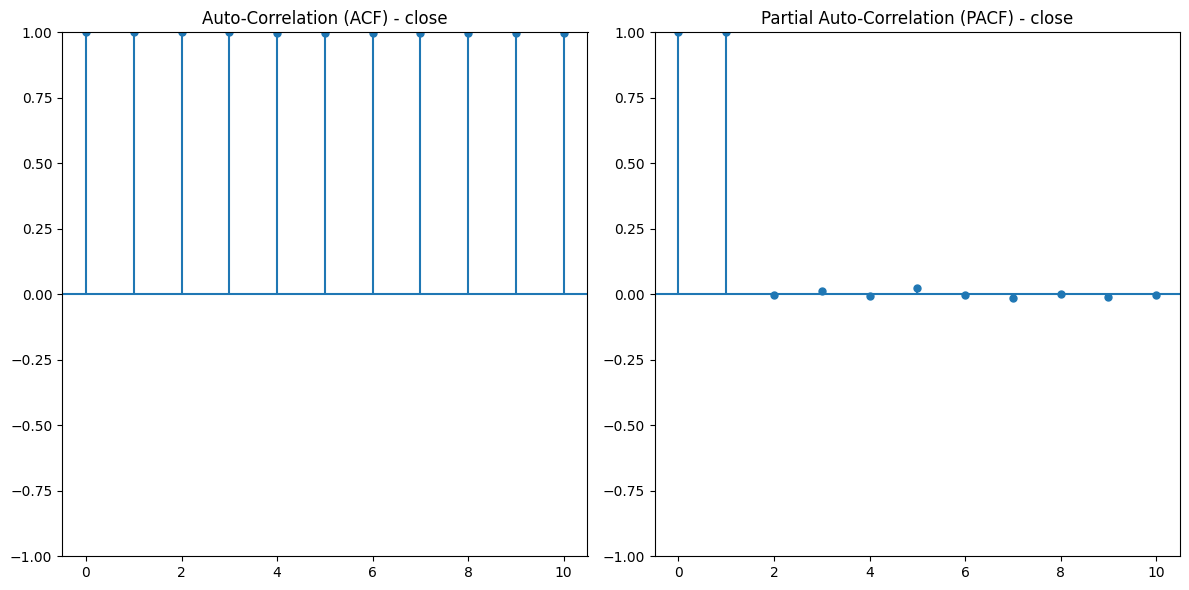

Checking feature: high


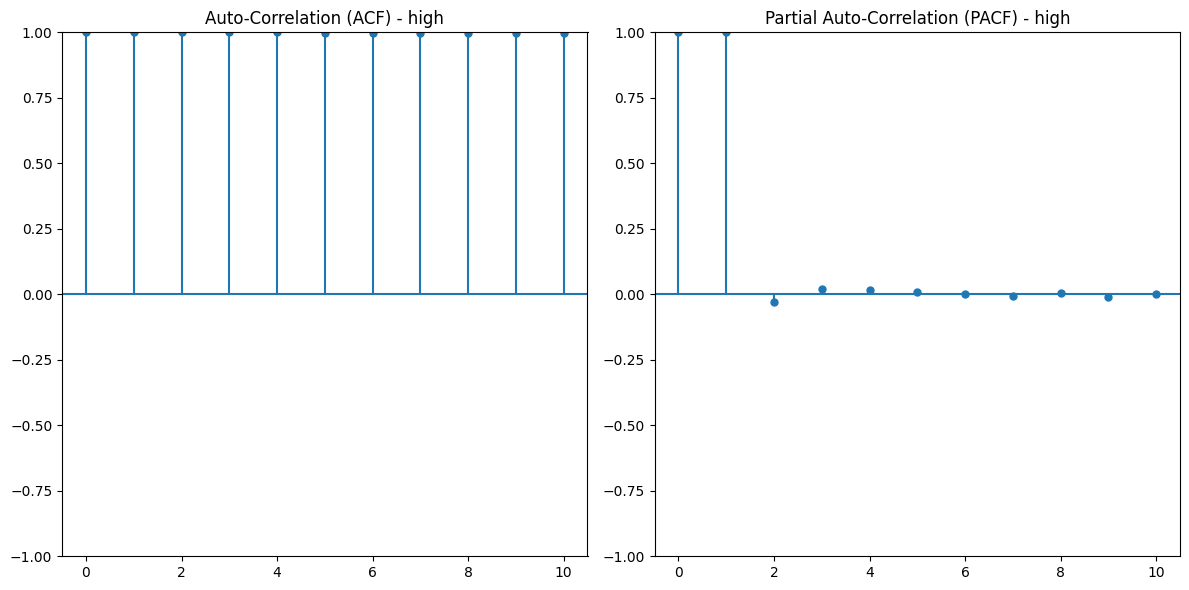

Checking feature: low


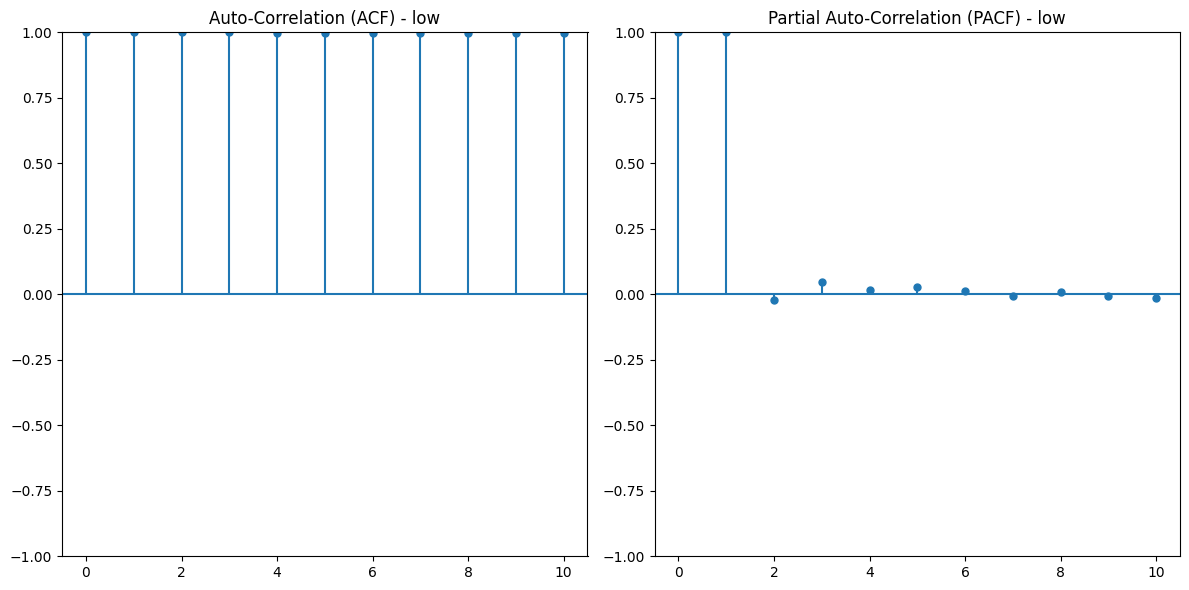

Checking feature: open


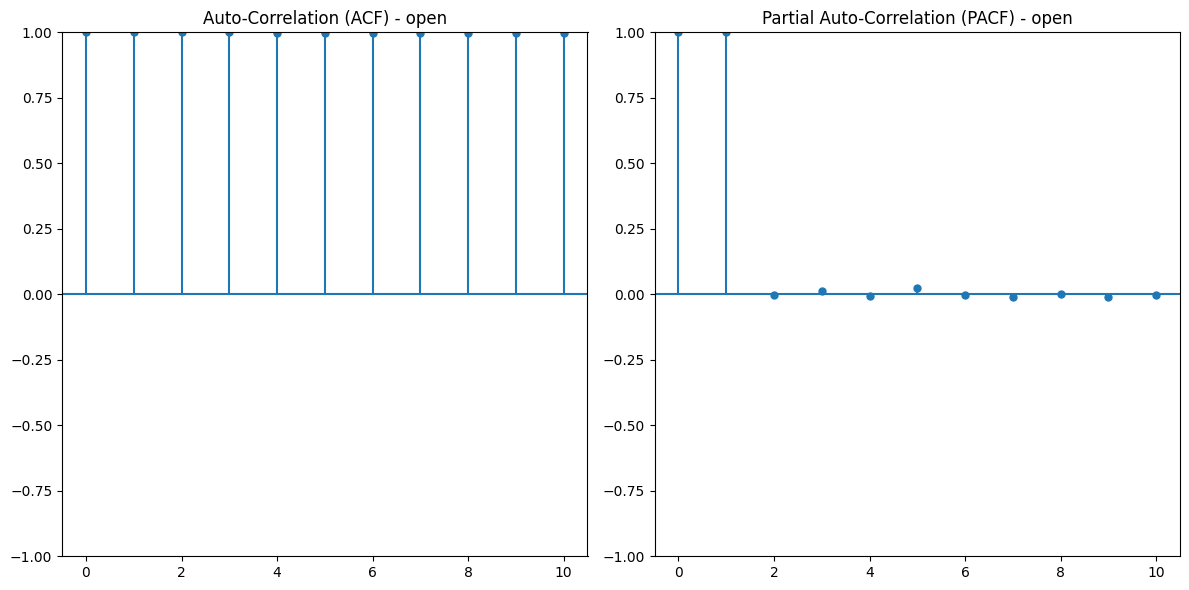

Checking feature: volume


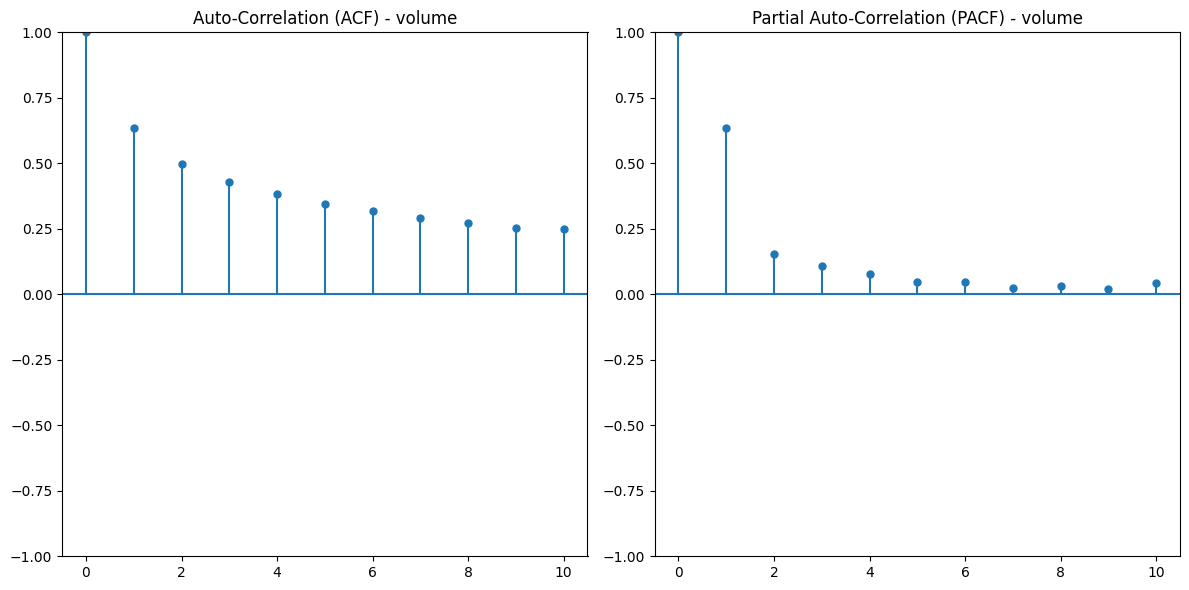

Checking feature: log_returns


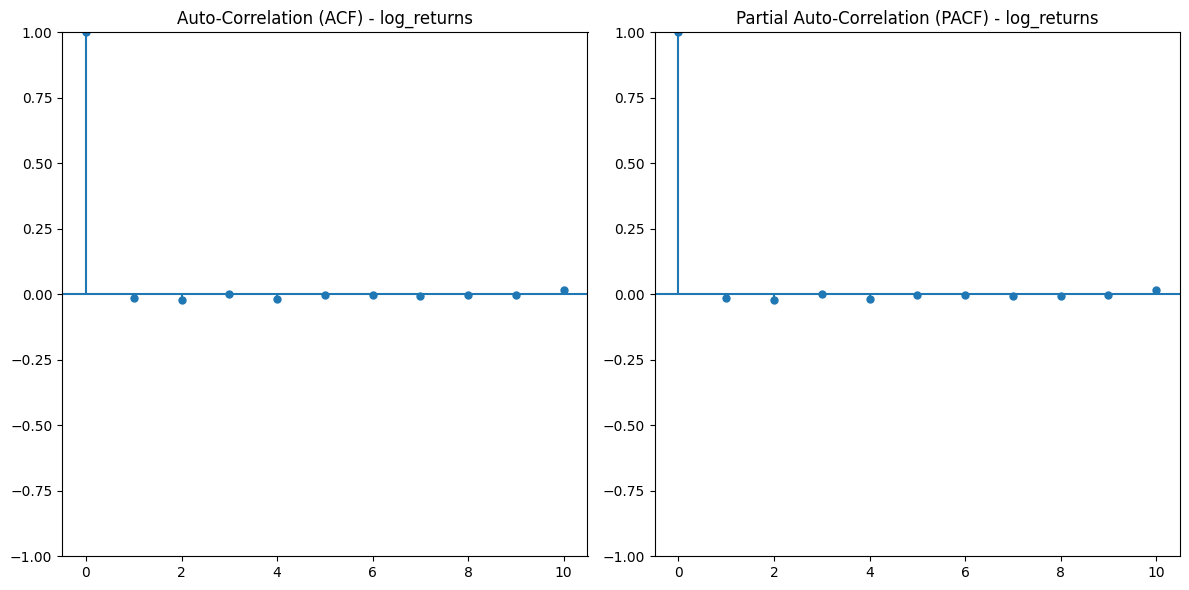

Checking feature: min_10k_count


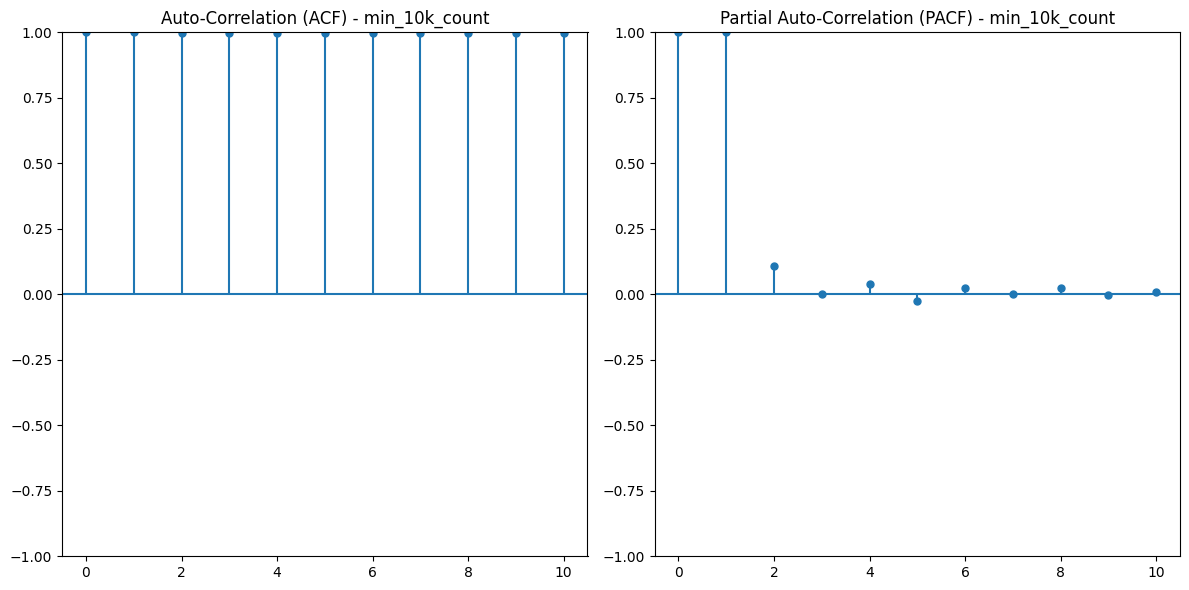

Checking feature: min_100_count


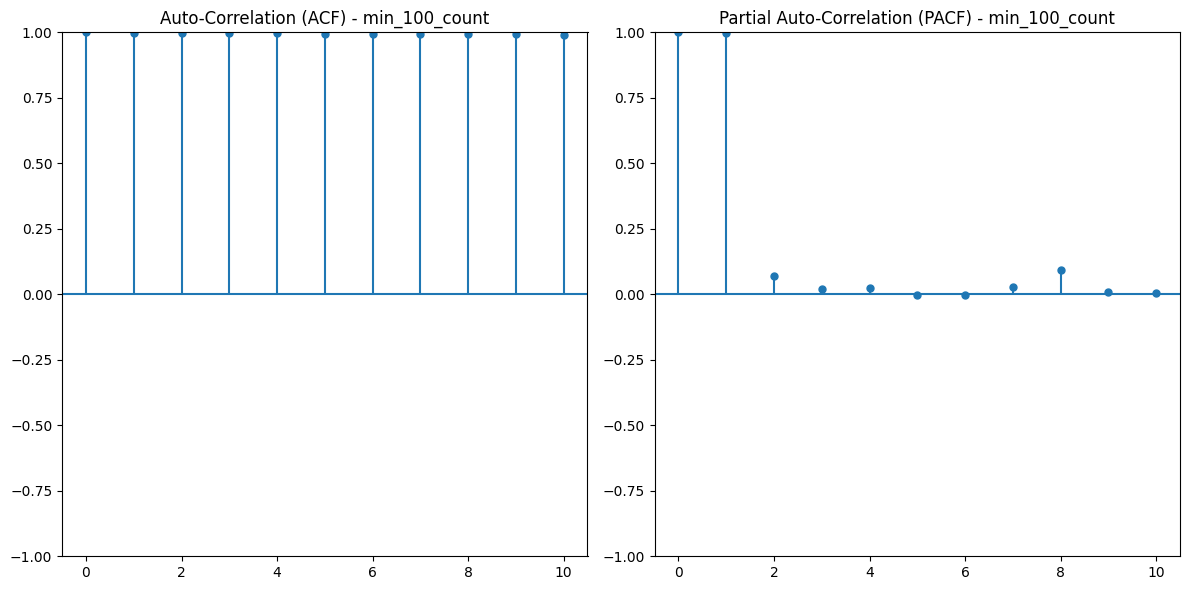

Checking feature: new_non_zero_count


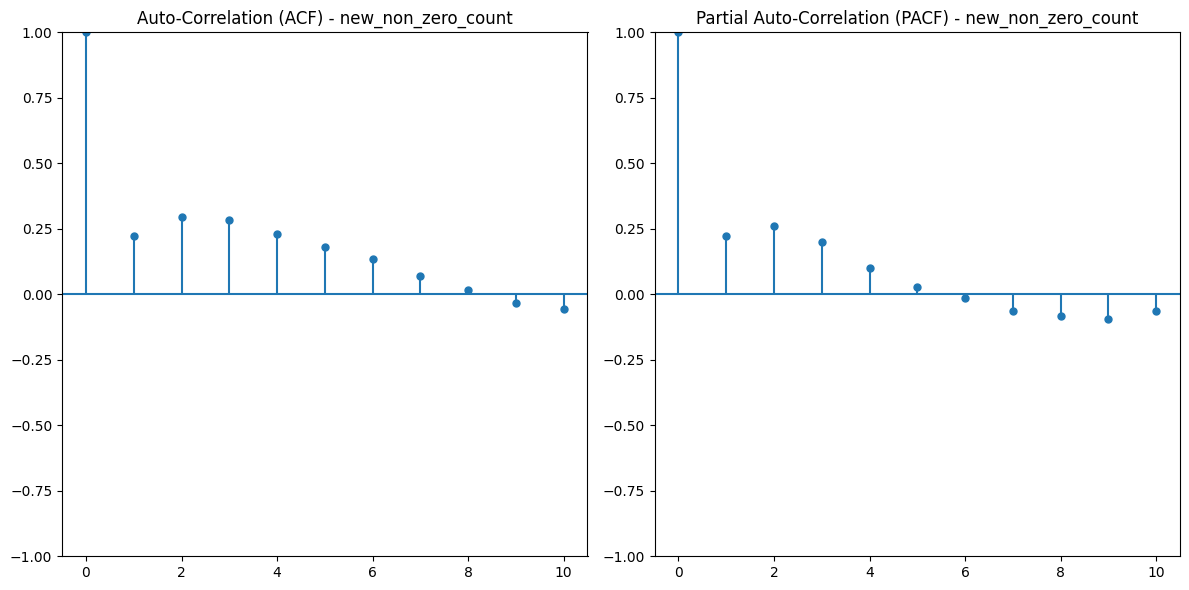

Checking feature: count


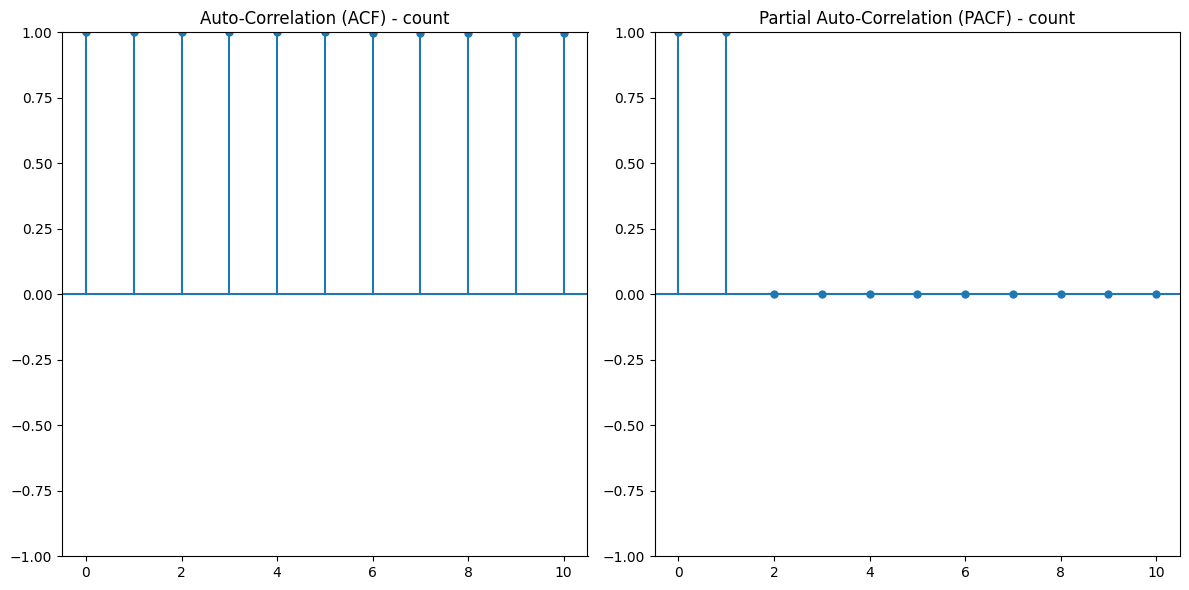

Checking feature: active_more_1y_percent


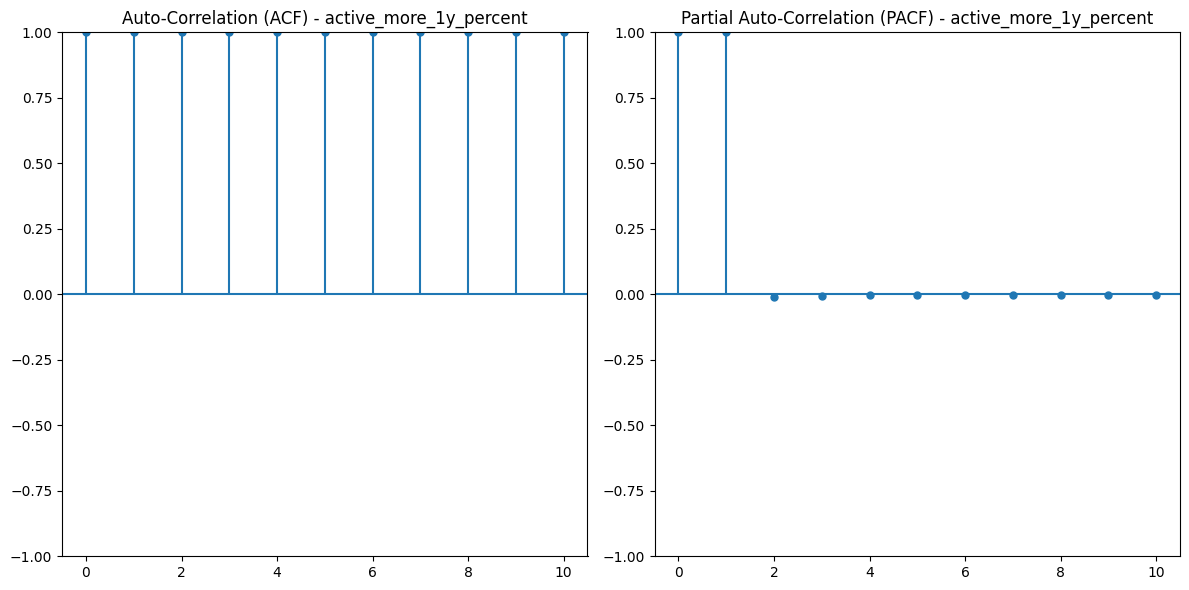

Checking feature: block_count


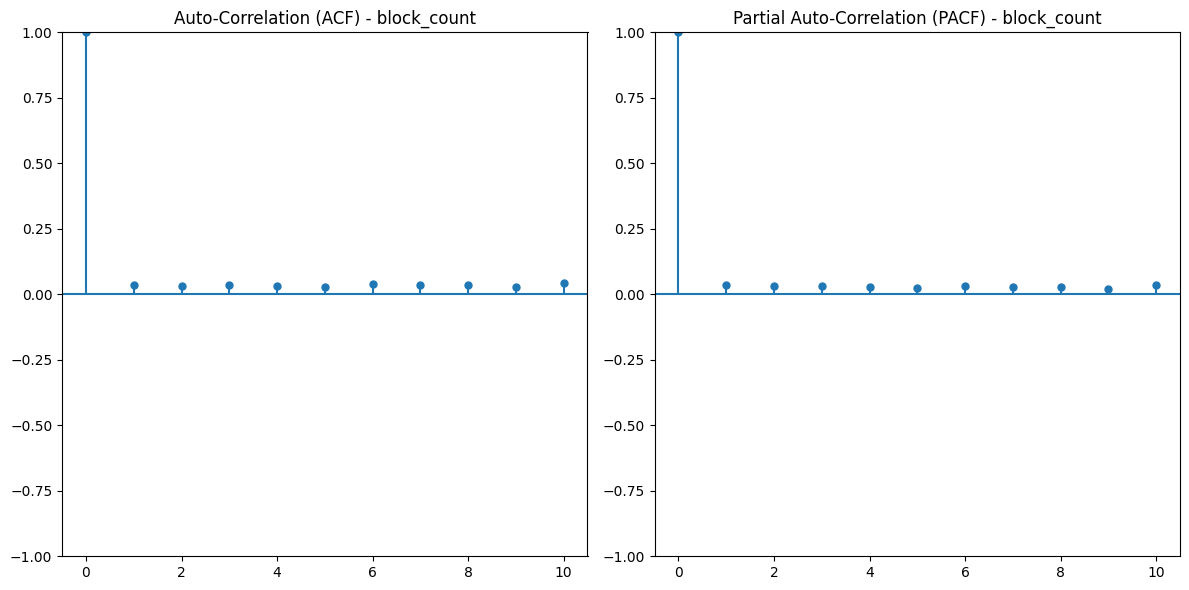

Checking feature: hash_rate_mean


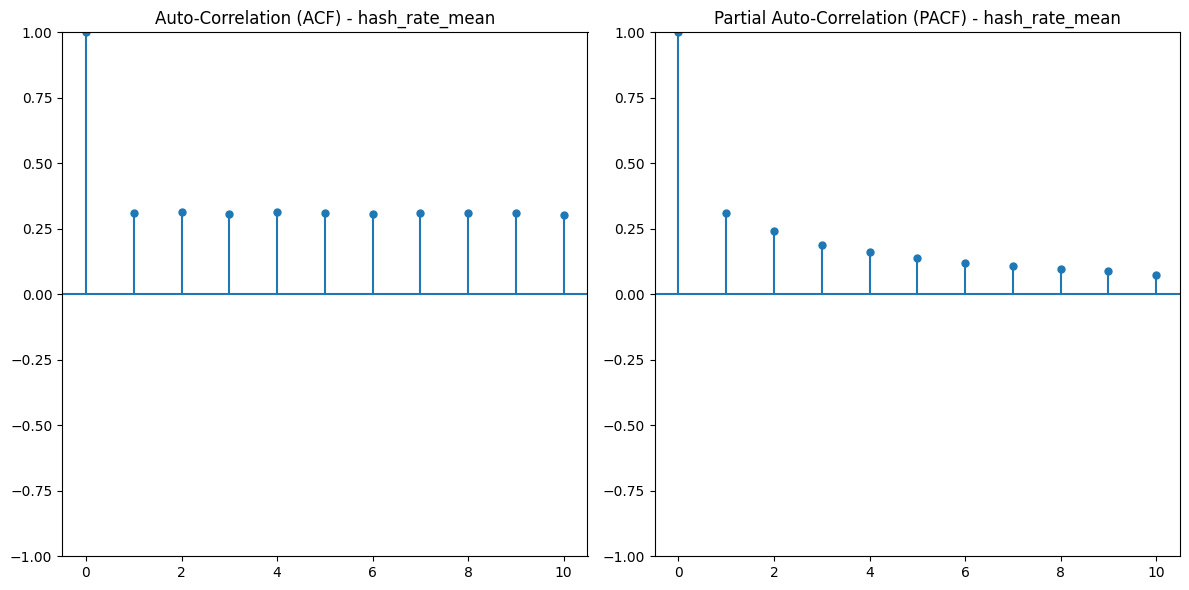

Checking feature: inflation_rate


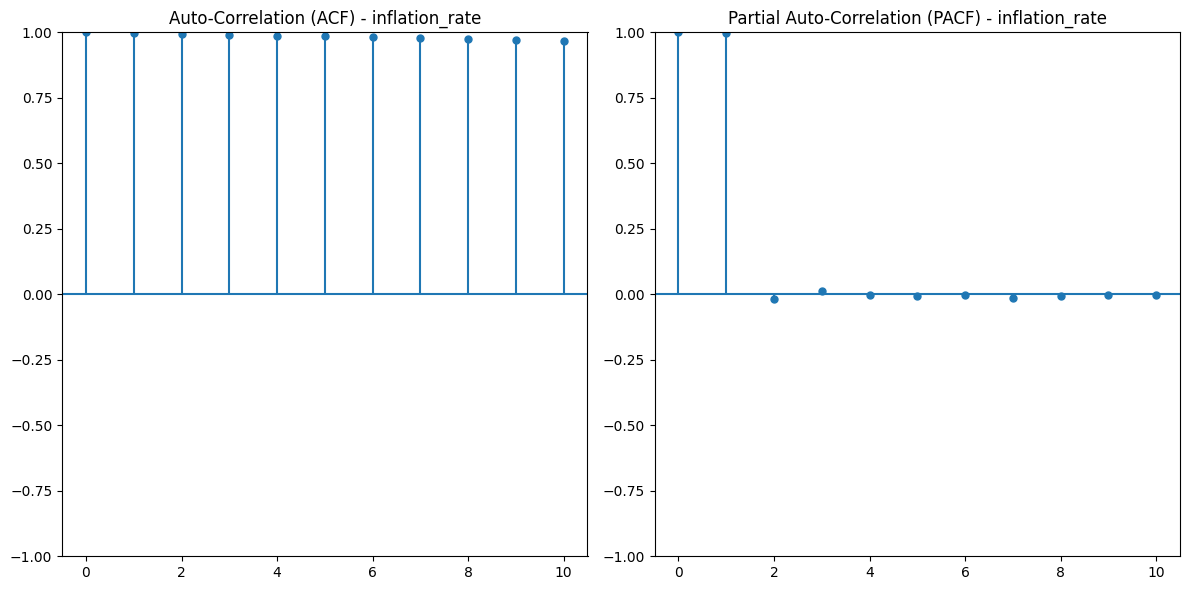

Checking feature: revenue_from_fees


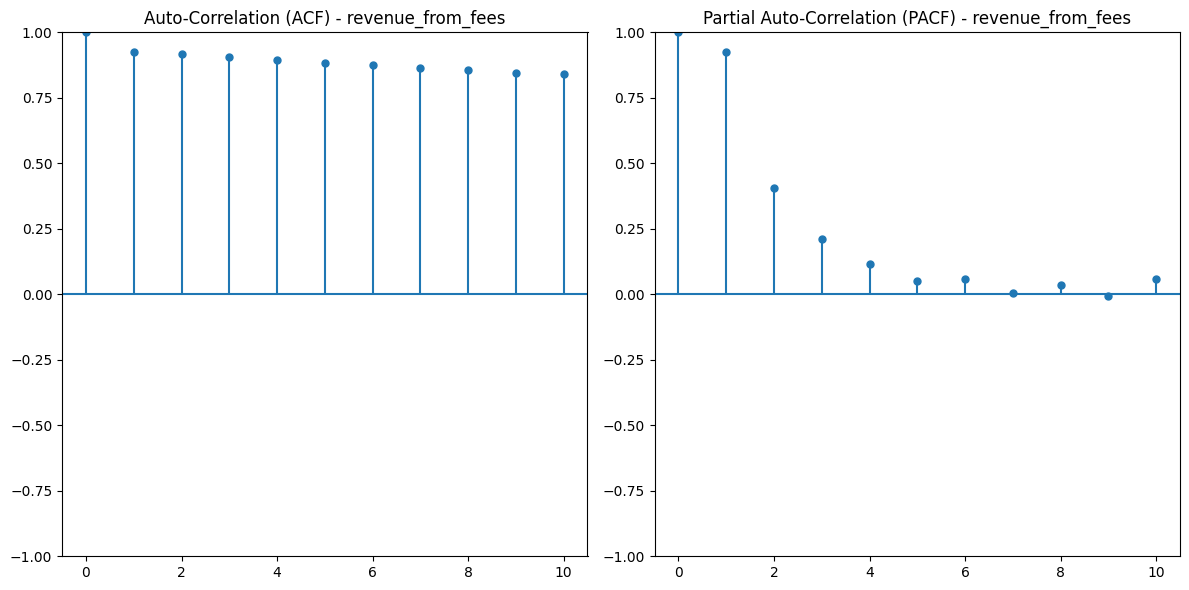

Checking feature: balance_exchanges


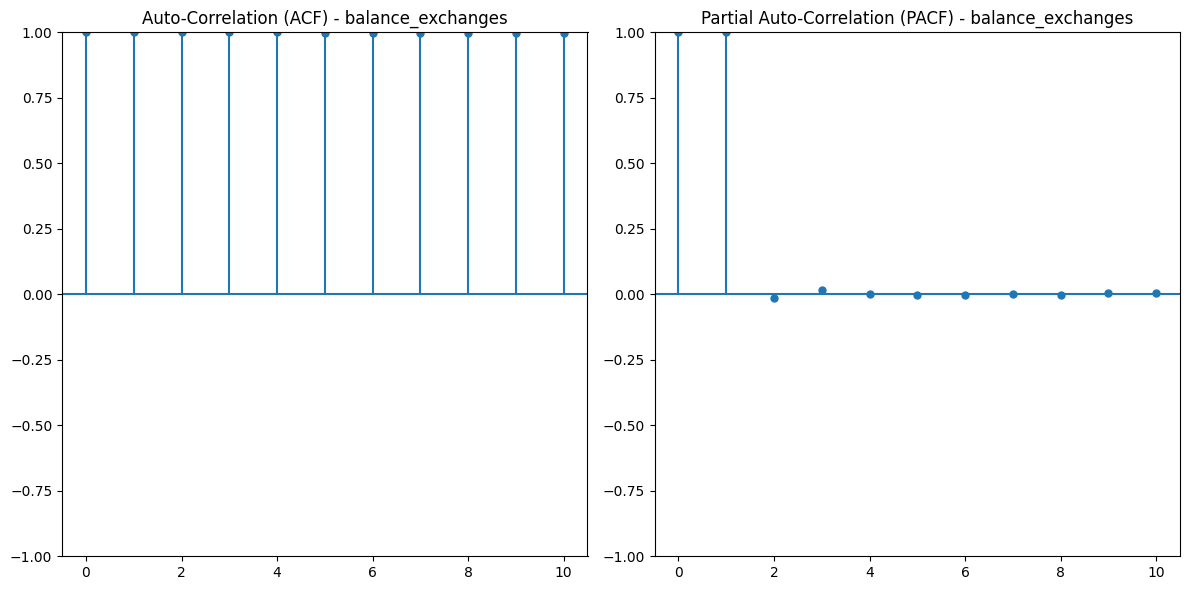

Checking feature: transfers_volume_to_exchanges_sum


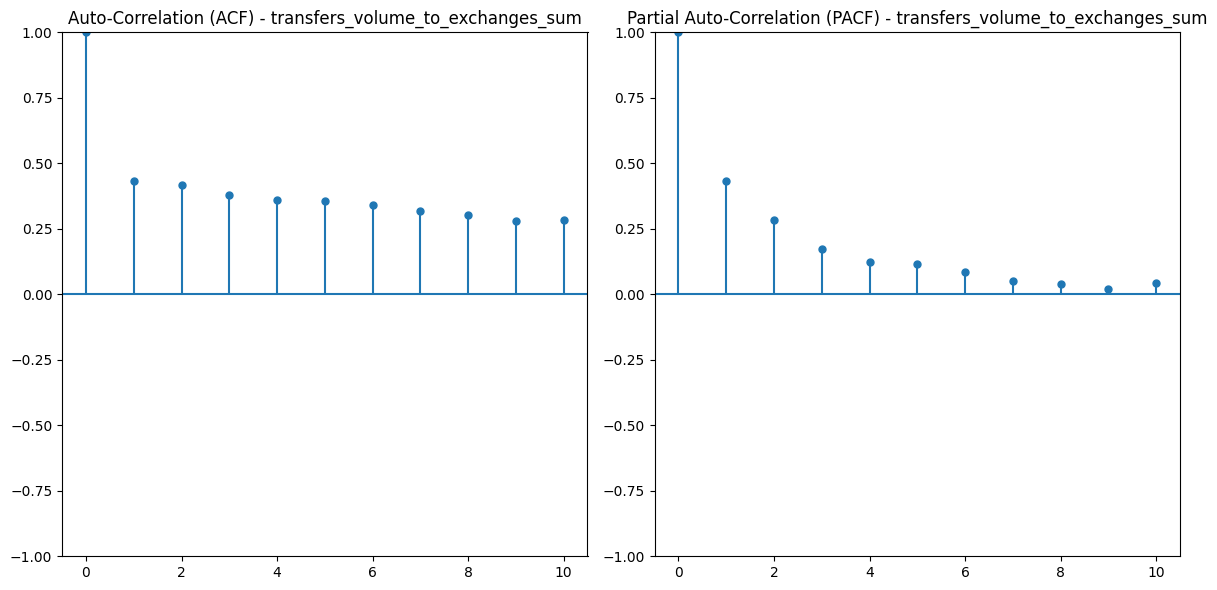

Checking feature: net_realized_profit_loss


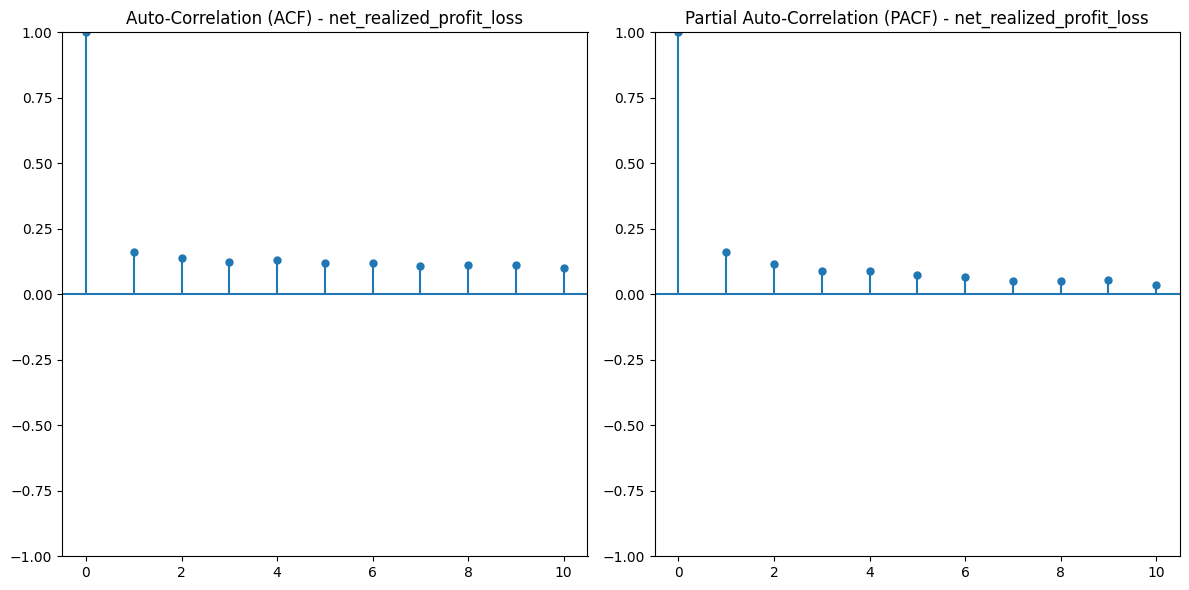

Checking feature: net_unrealized_profit_loss


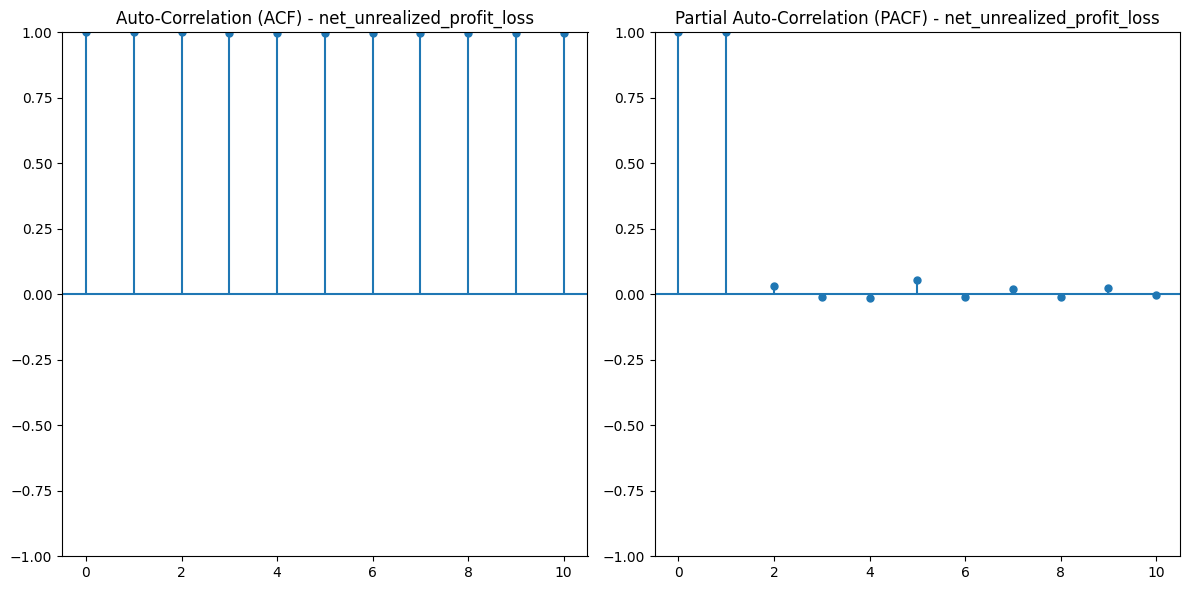

Checking feature: realized_loss


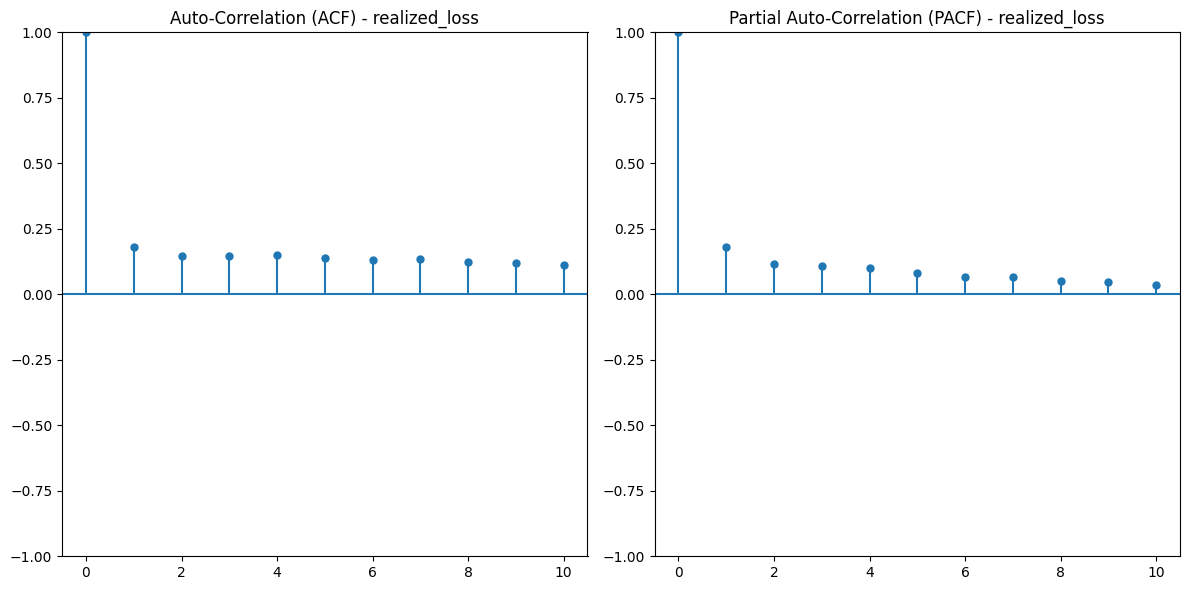

Checking feature: realized_profit


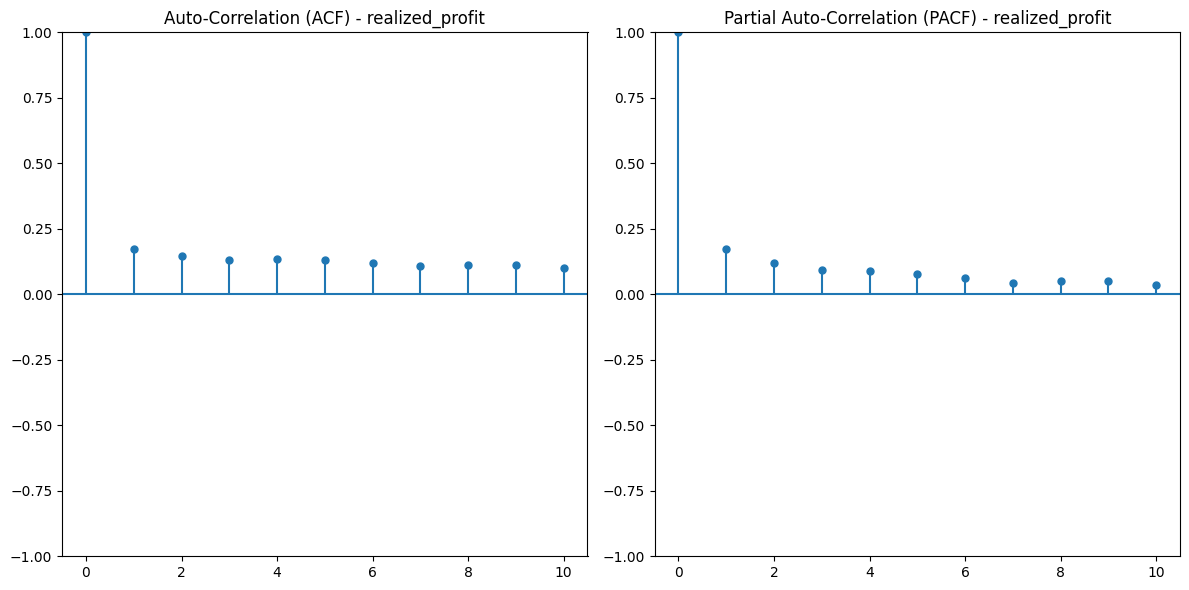

Checking feature: sopr


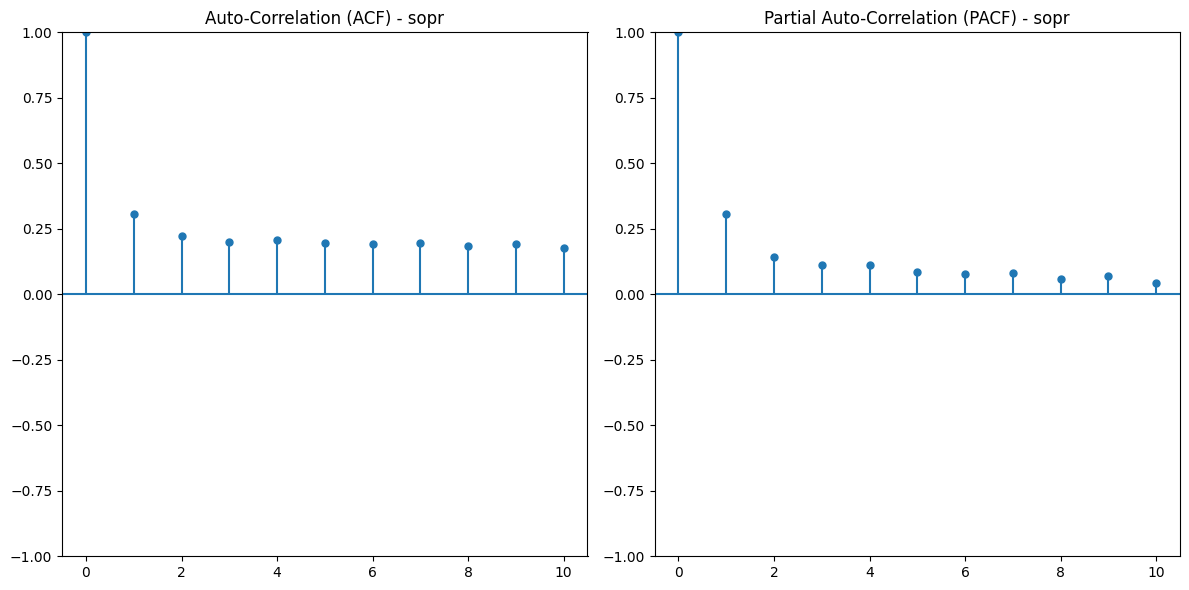

Checking feature: loss_sum


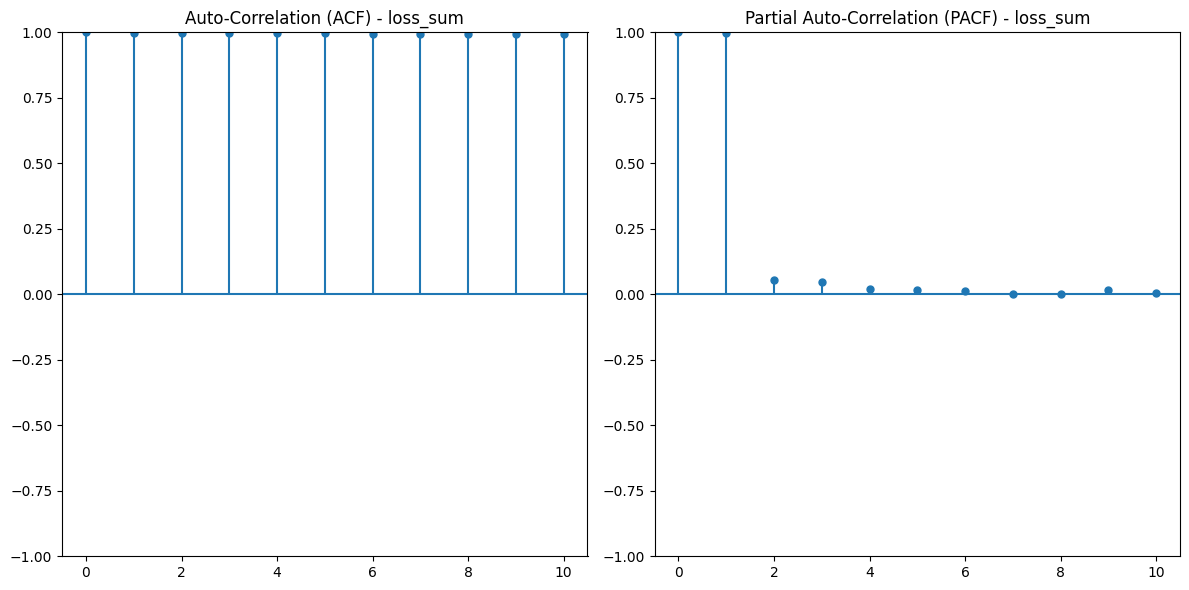

Checking feature: liveliness


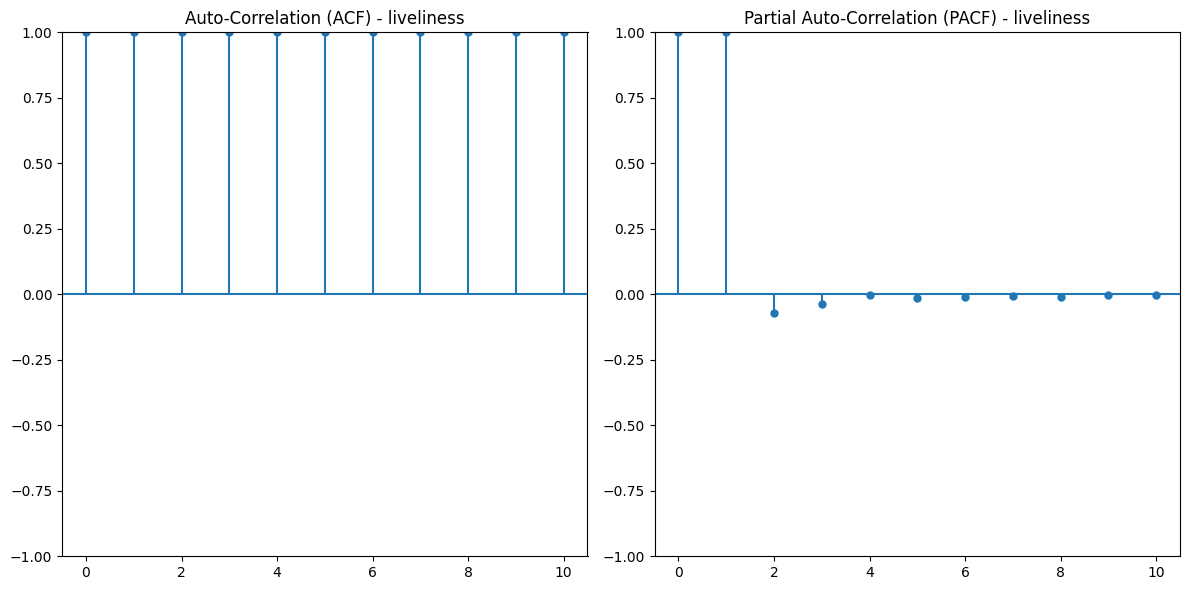

Checking feature: nvt


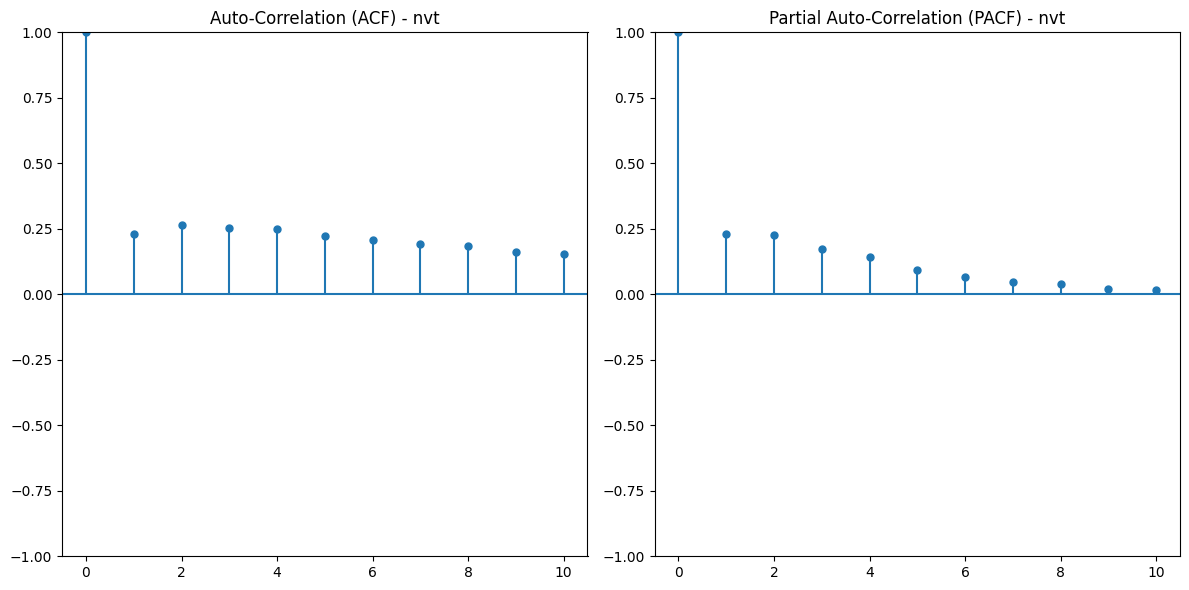

Checking feature: nvts


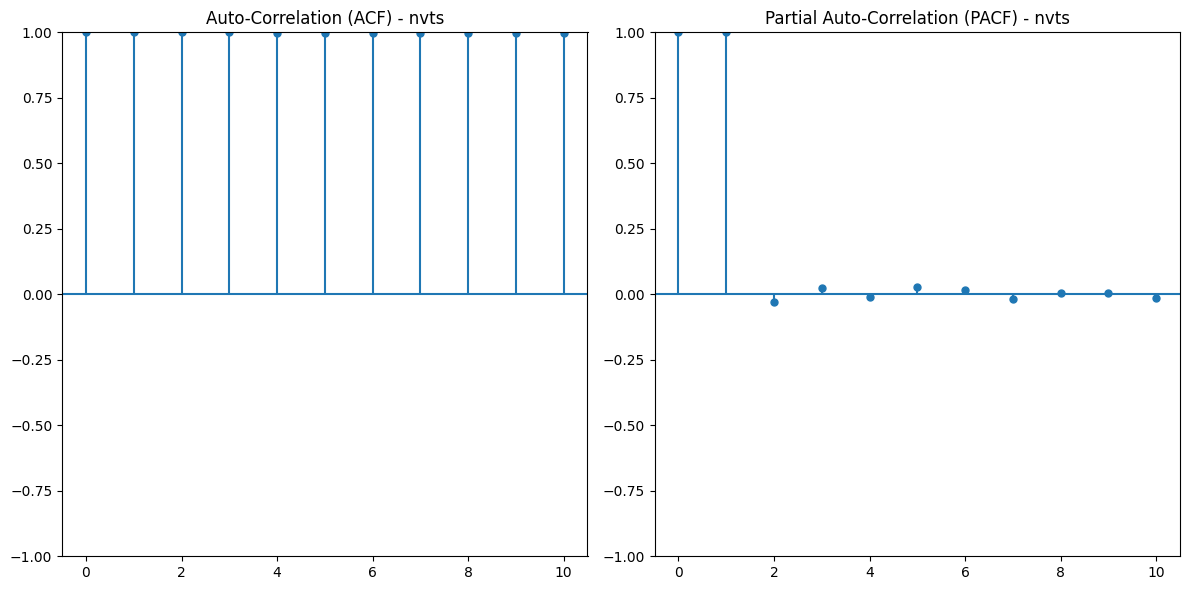

Checking feature: reserve_risk


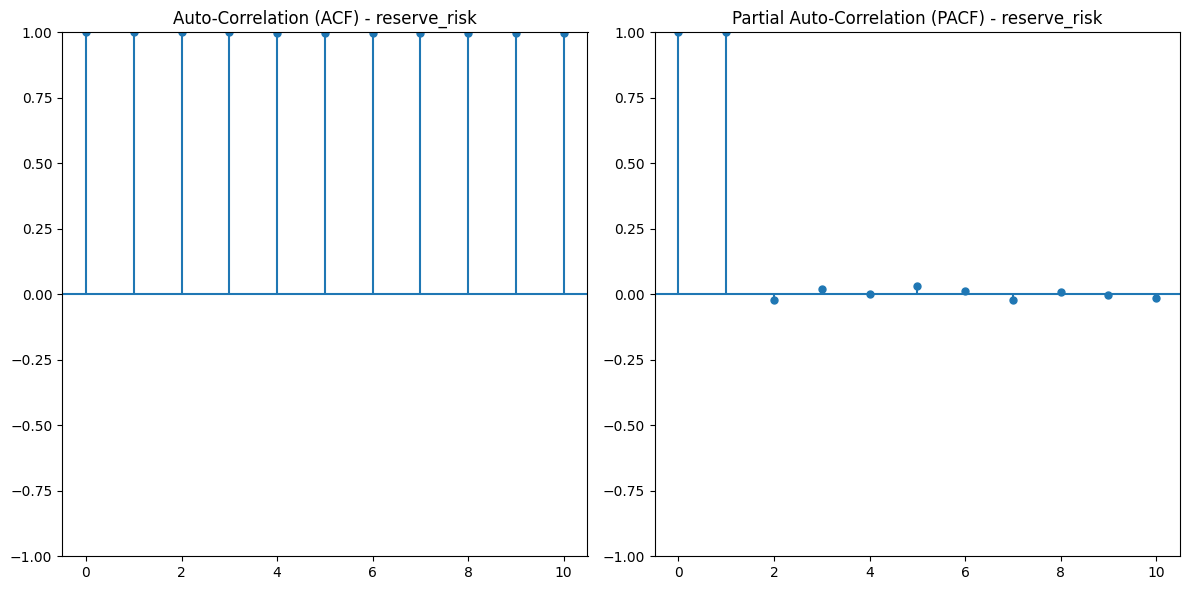

Checking feature: rhodl_ratio


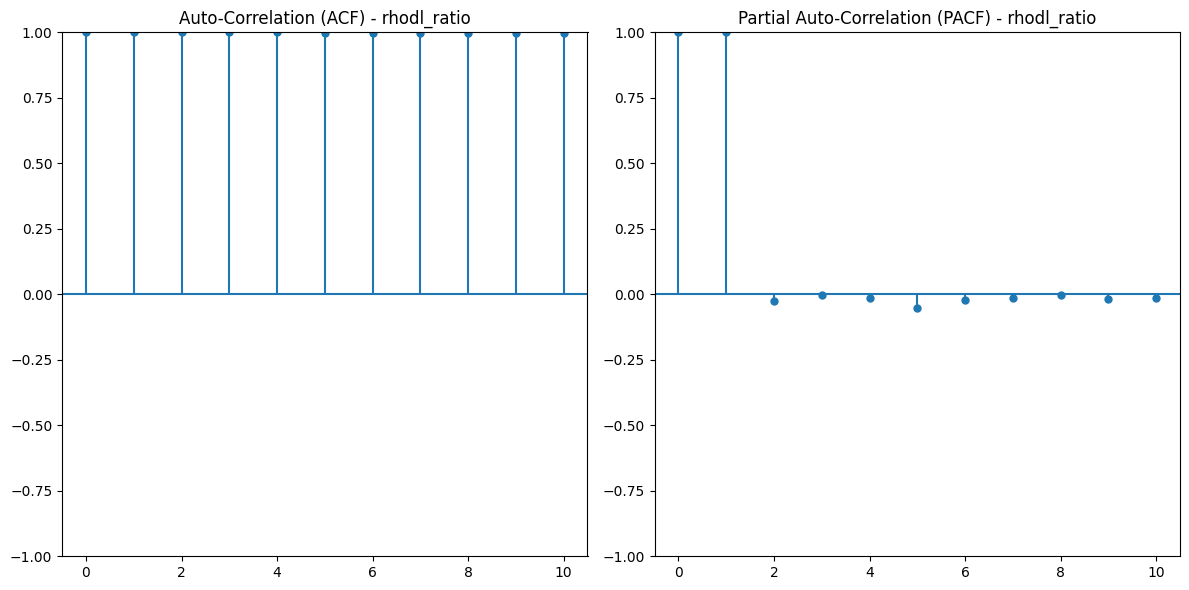

Checking feature: stock_to_flow_deflection


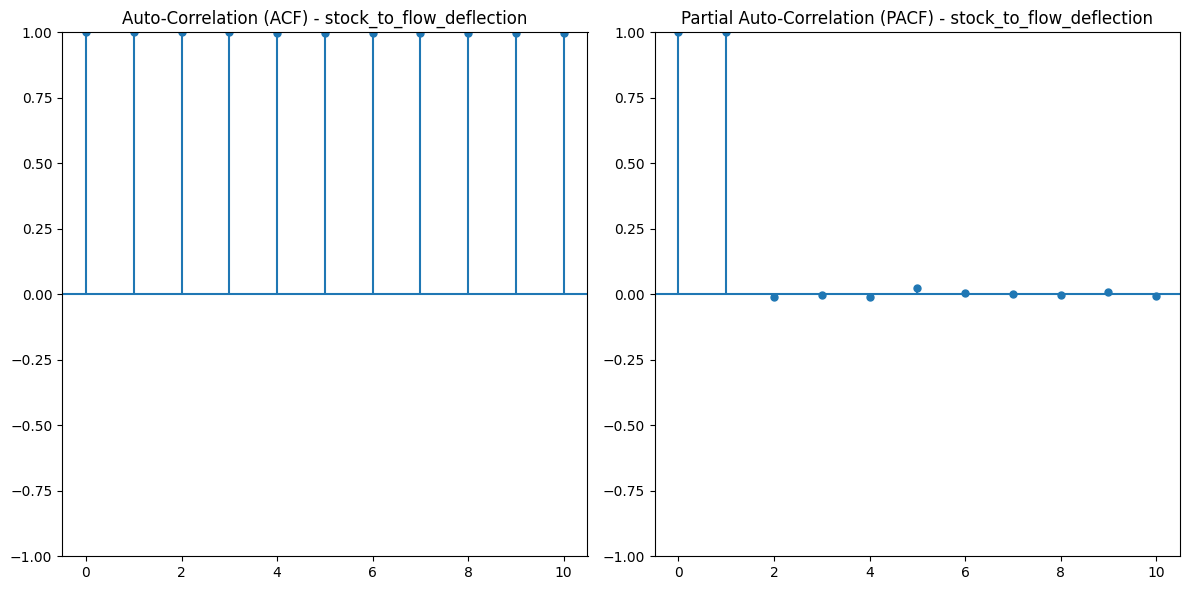

Checking feature: utxo_created_count


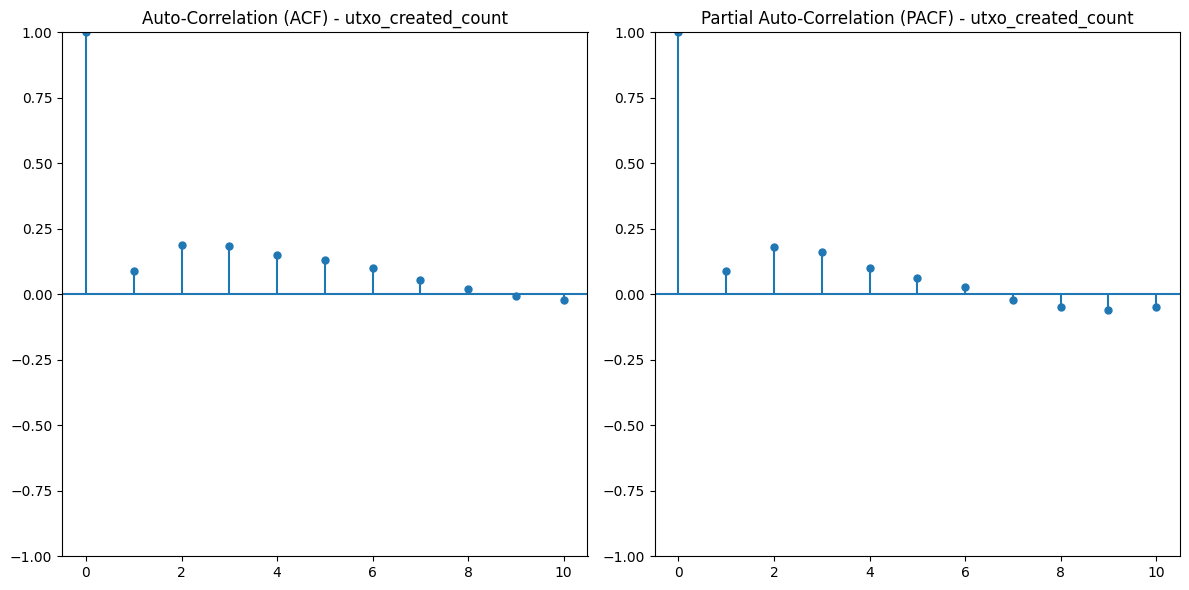

Checking feature: velocity


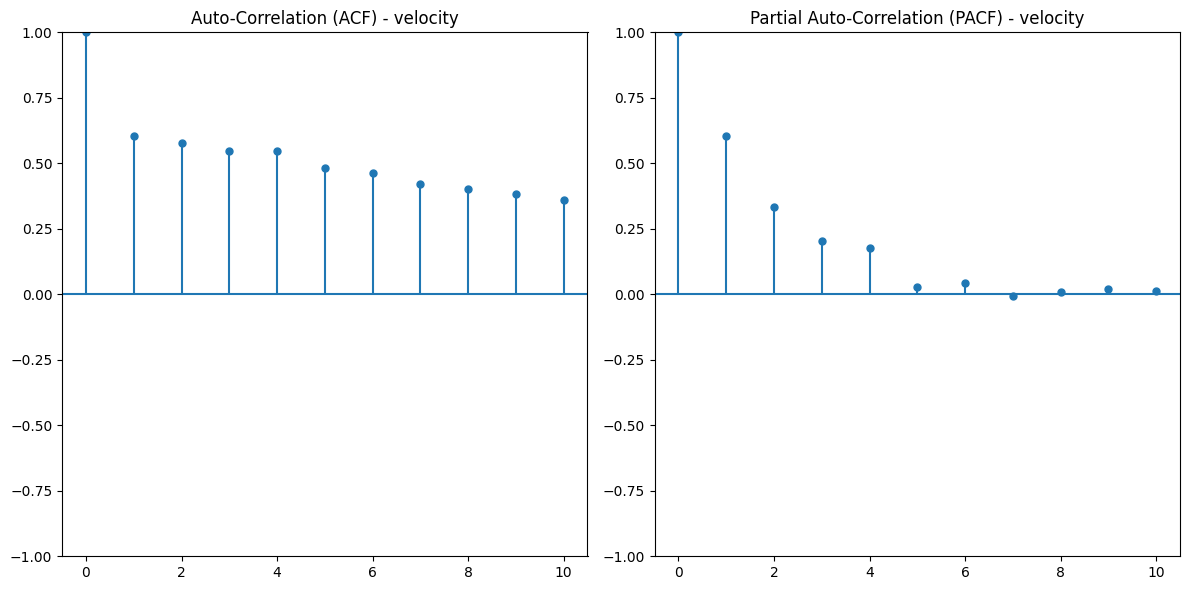

Checking feature: ATR


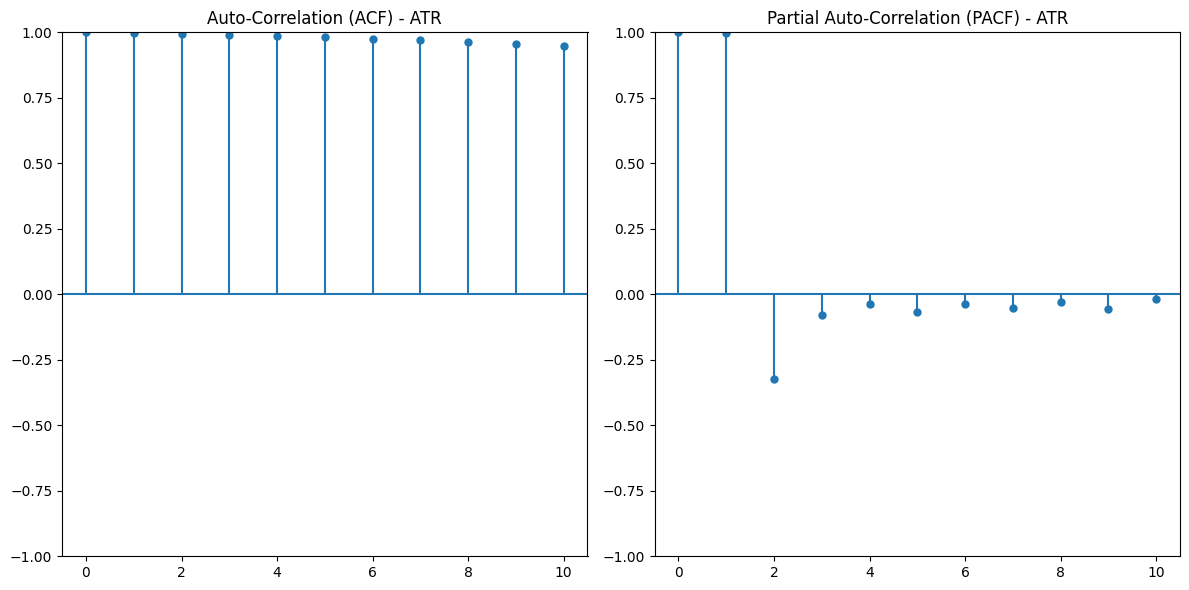

Checking feature: sma14


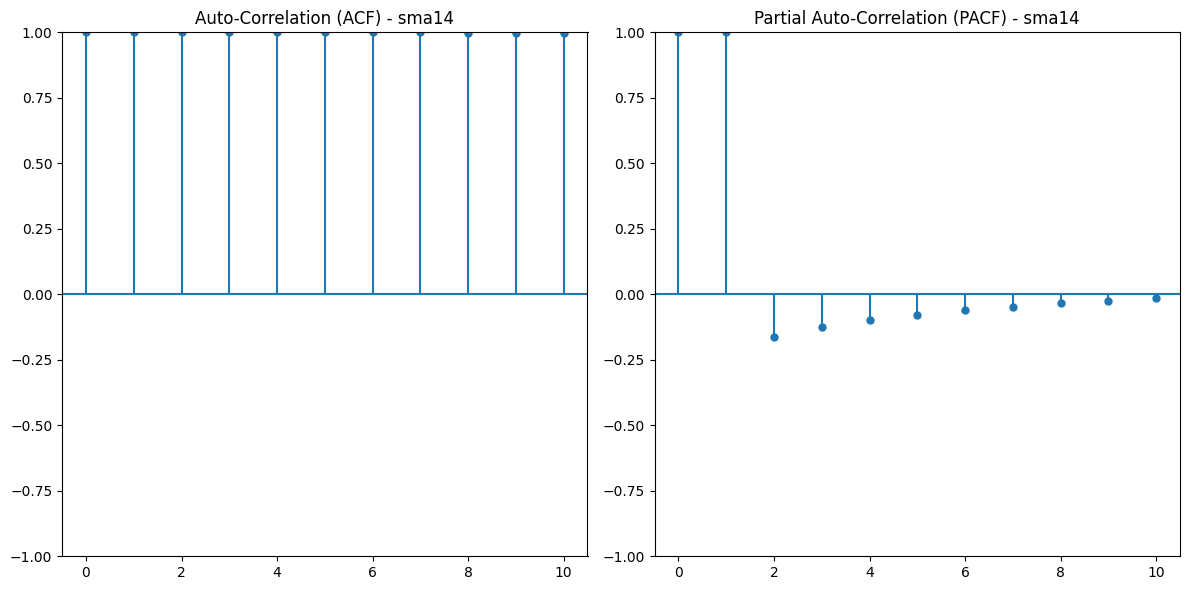

Checking feature: sma60


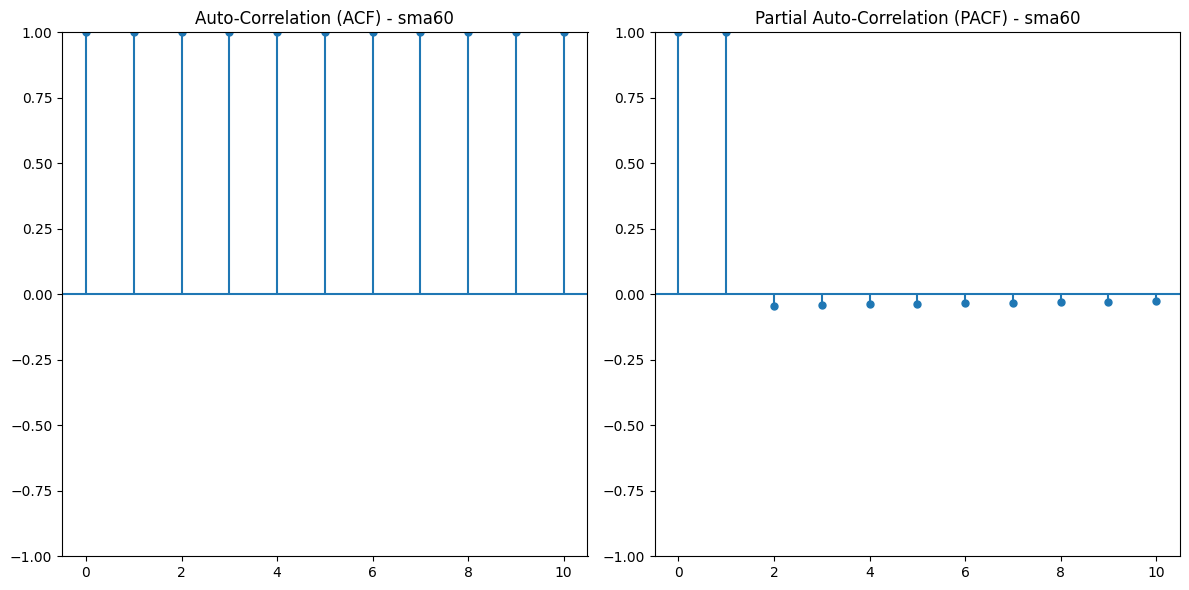

Checking feature: vol14


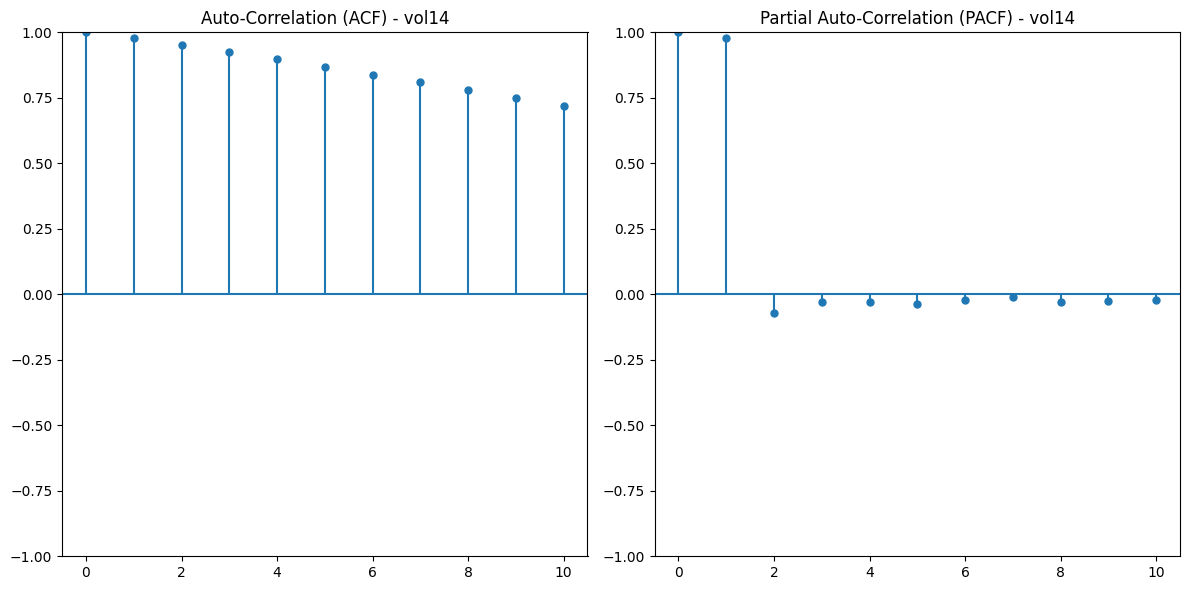

Checking feature: vol60


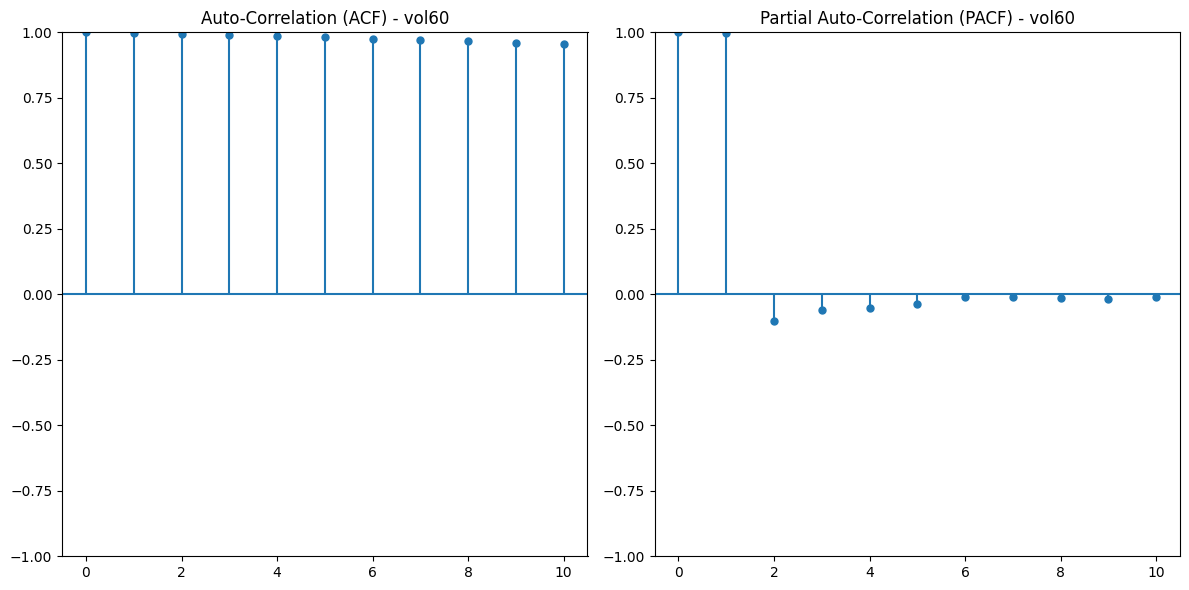

Checking feature: sma20


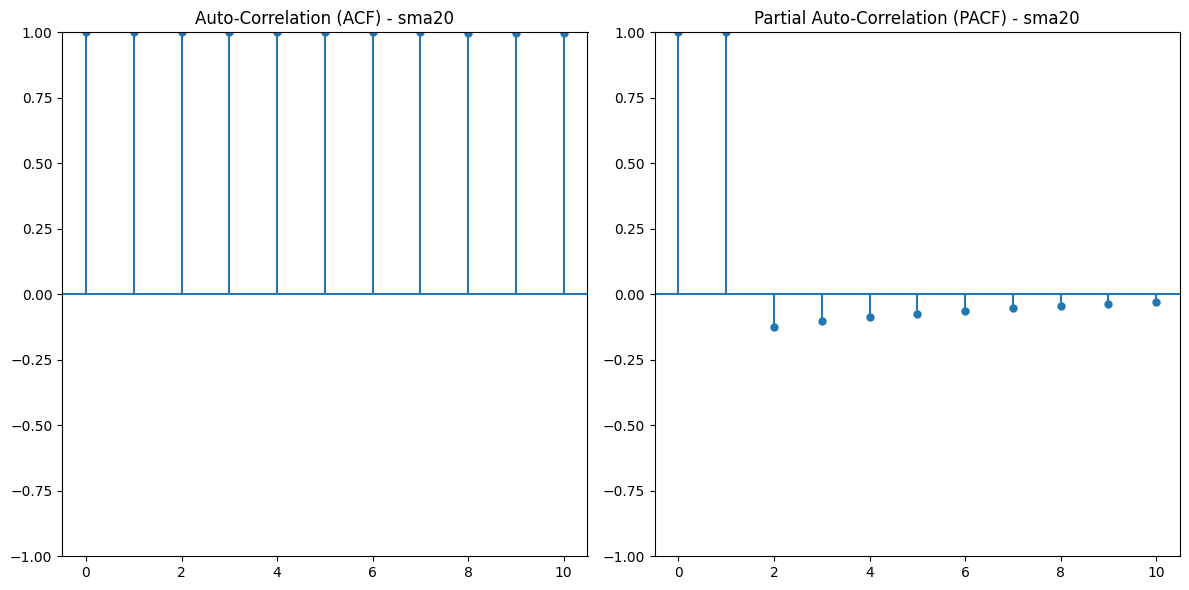

Checking feature: b_upper


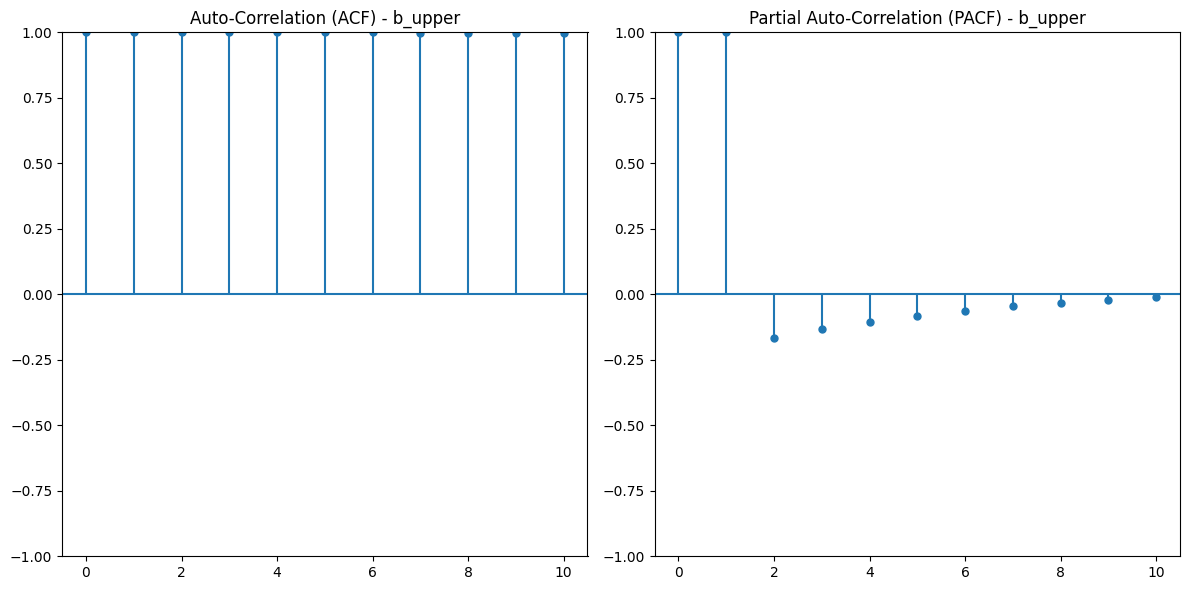

Checking feature: b_lower


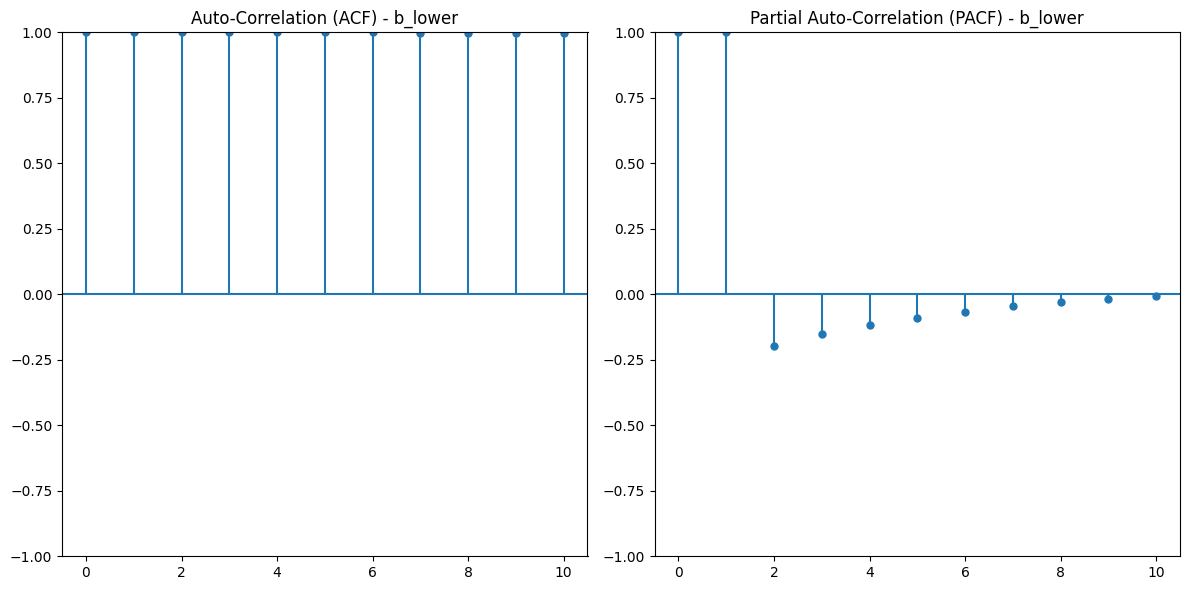

Checking feature: MOM5D


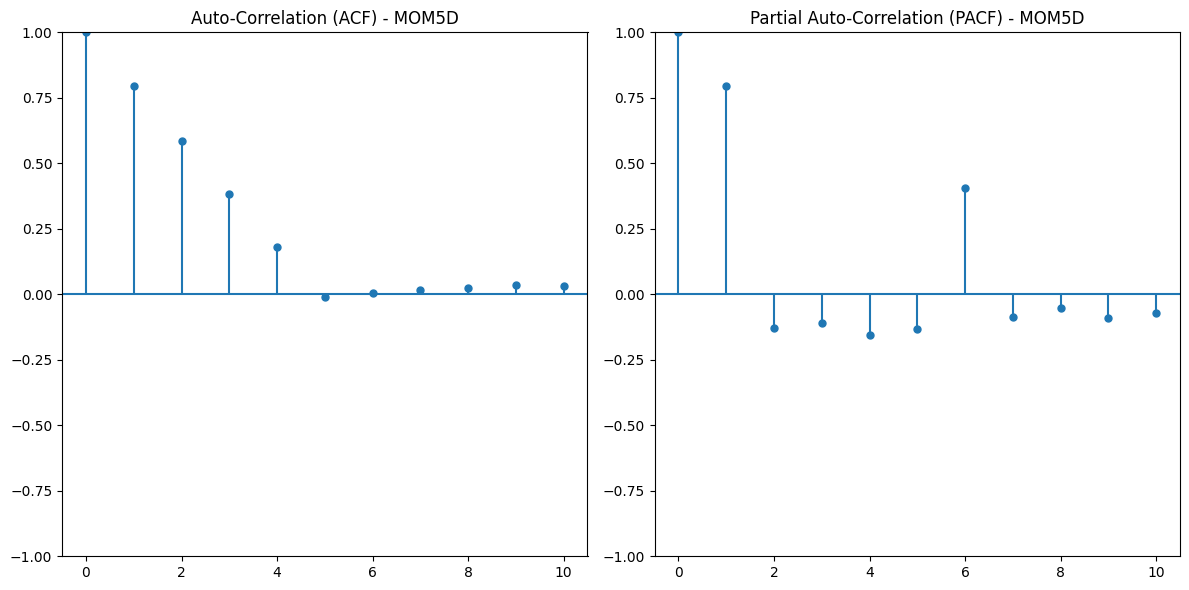

In [14]:
def check_acf_pacf_for_each_feature(df, max_lags=10):
    """
    This function checks and plots ACF and PACF for each feature in the DataFrame.

    :param df: DataFrame containing the time series data.
    :param max_lags: Maximum number of lags to consider (default is 10).
    """
    
    # Iterate over each column (feature) in the DataFrame
    for feature in df.columns:
        print(f"Checking feature: {feature}")
        
        # Plot ACF for this feature
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plot_acf(df[feature].dropna(), lags=max_lags, alpha=None, fft=True, ax=plt.gca())
        plt.title(f"Auto-Correlation (ACF) - {feature}")
        
        # Plot PACF for this feature
        plt.subplot(1, 2, 2)
        plot_pacf(df[feature].dropna(), lags=max_lags, alpha=None, ax=plt.gca())
        plt.title(f"Partial Auto-Correlation (PACF) - {feature}")
        
        # Show the plots
        plt.tight_layout()
        plt.show()

check_acf_pacf_for_each_feature(df, max_lags=10)

**Based on the ACF and PACF plots:**

The ACF shows high correlation across multiple lags, while the PACF drops sharply after lag 1. This suggests that only the most recent time step has a strong direct influence on the current value. Therefore, adding additional lag features is unlikely to provide significant new information. No additional lags are added.

## Labels Generation & Checking the class imbalance

In [15]:
Y = pd.DataFrame(list(np.where(df["log_returns"] >0, 1, -1)))

In [16]:
Y

,0
0,1
1,1
2,1
3,-1
4,-1
...,...
26239,1
26240,1
26241,-1
26242,-1


In [17]:
class_counts = Y[0].value_counts()

print("Class distribution: ", class_counts)
print("\nPercentage distribution: ", class_counts/len(Y)*100)

Class distribution:  0
 1    13318
-1    12926
Name: count, dtype: int64

Percentage distribution:  0
 1    50.746837
-1    49.253163
Name: count, dtype: float64


## Split the data

In [18]:
X = df.copy().dropna()

In [19]:
X.head()

,close,high,low,open,volume,log_returns,min_10k_count,min_100_count,new_non_zero_count,count,...,velocity,ATR,sma14,sma60,vol14,vol60,sma20,b_upper,b_lower,MOM5D
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-04 04:00:00,7330.28,7334.29,7310.00,7329.40,2216.484,0.000135,108,16240,9121,596925100,...,0.000364,65.102381,7325.274286,7182.933333,0.089904,0.128690,7323.3720,7509.657260,7137.086740,-11.44
2020-01-04 05:00:00,7341.00,7368.47,7321.00,7330.81,3894.950,0.001461,108,16242,10701,596935801,...,0.000768,62.505714,7327.059286,7184.720000,0.078902,0.128683,7323.1645,7503.447422,7142.881578,38.13
2020-01-04 06:00:00,7351.50,7362.15,7335.22,7341.00,3585.856,0.001429,108,16245,11236,596947037,...,0.000568,58.739524,7324.809286,7186.620500,0.062745,0.128715,7325.2395,7497.162200,7153.316800,46.28
2020-01-04 07:00:00,7344.13,7358.02,7322.45,7350.92,3706.647,-0.001003,108,16247,9561,596956598,...,0.000690,56.248095,7324.182857,7188.583500,0.059417,0.128675,7325.5405,7486.783790,7164.297210,20.00
2020-01-04 08:00:00,7343.00,7359.00,7328.27,7344.11,2428.225,-0.000154,108,16246,11444,596968042,...,0.000540,55.847143,7324.367143,7190.411833,0.058759,0.128667,7326.6120,7475.505955,7177.718045,13.71


In [20]:
# Transform Y to a binary classification problem's values (0 and 1)
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Y = pd.DataFrame(encoded_Y, columns=["Target"], index=Y.index)

C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [21]:
class_counts = Y.value_counts()

print("Class distribution: ", class_counts)
print("\nPercentage distribution: ", class_counts/len(Y)*100)

Class distribution:  Target
1         13318
0         12926
Name: count, dtype: int64

Percentage distribution:  Target
1         50.746837
0         49.253163
Name: count, dtype: float64


In [22]:
# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [23]:
print("X_train's shape: ", X_train.shape)
print("y_train's shape: ", y_train.shape)
print("X_test's shape: ", X_test.shape)
print("y_test's shape: ", y_test.shape)

X_train's shape:  (18370, 40)
y_train's shape:  (18370, 1)
X_test's shape:  (7874, 40)
y_test's shape:  (7874, 1)


In [53]:
type(X_train)

pandas.core.frame.DataFrame

## Feature Selection & Feature Importance

### Feature Selection

In [24]:
# We apply SelectKBest class to order the most relevant features with respect to f_classif
bestfeatures = SelectKBest(score_func = f_classif, k = len(X_train.keys()))
fit = bestfeatures.fit(X_train, y_train)

# we concatenate two dataframes for better visualization 
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(X_train.keys()),'Score'))  

                                Specs         Score
5                         log_returns  10309.920716
39                              MOM5D    724.040722
19                      realized_loss     59.045950
21                               sopr     39.426790
29                 utxo_created_count     12.445283
17           net_realized_profit_loss     11.228525
4                              volume      9.919368
25                               nvts      8.549715
8                  new_non_zero_count      7.217153
3                                open      6.010226
22                           loss_sum      5.987709
38                            b_lower      4.774403
11                        block_count      4.691579
36                              sma20      4.659085
32                              sma14      4.647787
37                            b_upper      4.543458
33                              sma60      4.529057
16  transfers_volume_to_exchanges_sum      3.838101
15          

C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
best_15_features = list(featureScores.nlargest(15,'Score')['Specs'])
for i in list(featureScores['Specs']):
    if(i not in best_15_features):
        X_train.drop(i,axis = 1,inplace = True)

In [26]:
X_train.keys()

Index(['open', 'volume', 'log_returns', 'new_non_zero_count', 'block_count',
       'net_realized_profit_loss', 'realized_loss', 'sopr', 'loss_sum', 'nvts',
       'utxo_created_count', 'sma14', 'sma20', 'b_lower', 'MOM5D'],
      dtype='object')

### Feature Importance

C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.03211129 0.03549131 0.54116862 0.03119325 0.02805712 0.03192247
 0.03888566 0.03183469 0.03026008 0.02903315 0.0313207  0.02803615
 0.02783001 0.0282984  0.0545571 ]


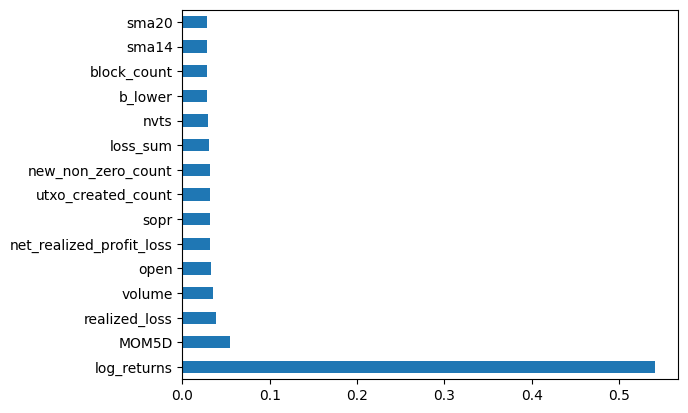

In [27]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(len(X_train.keys())).plot(kind = 'barh')
plt.show()

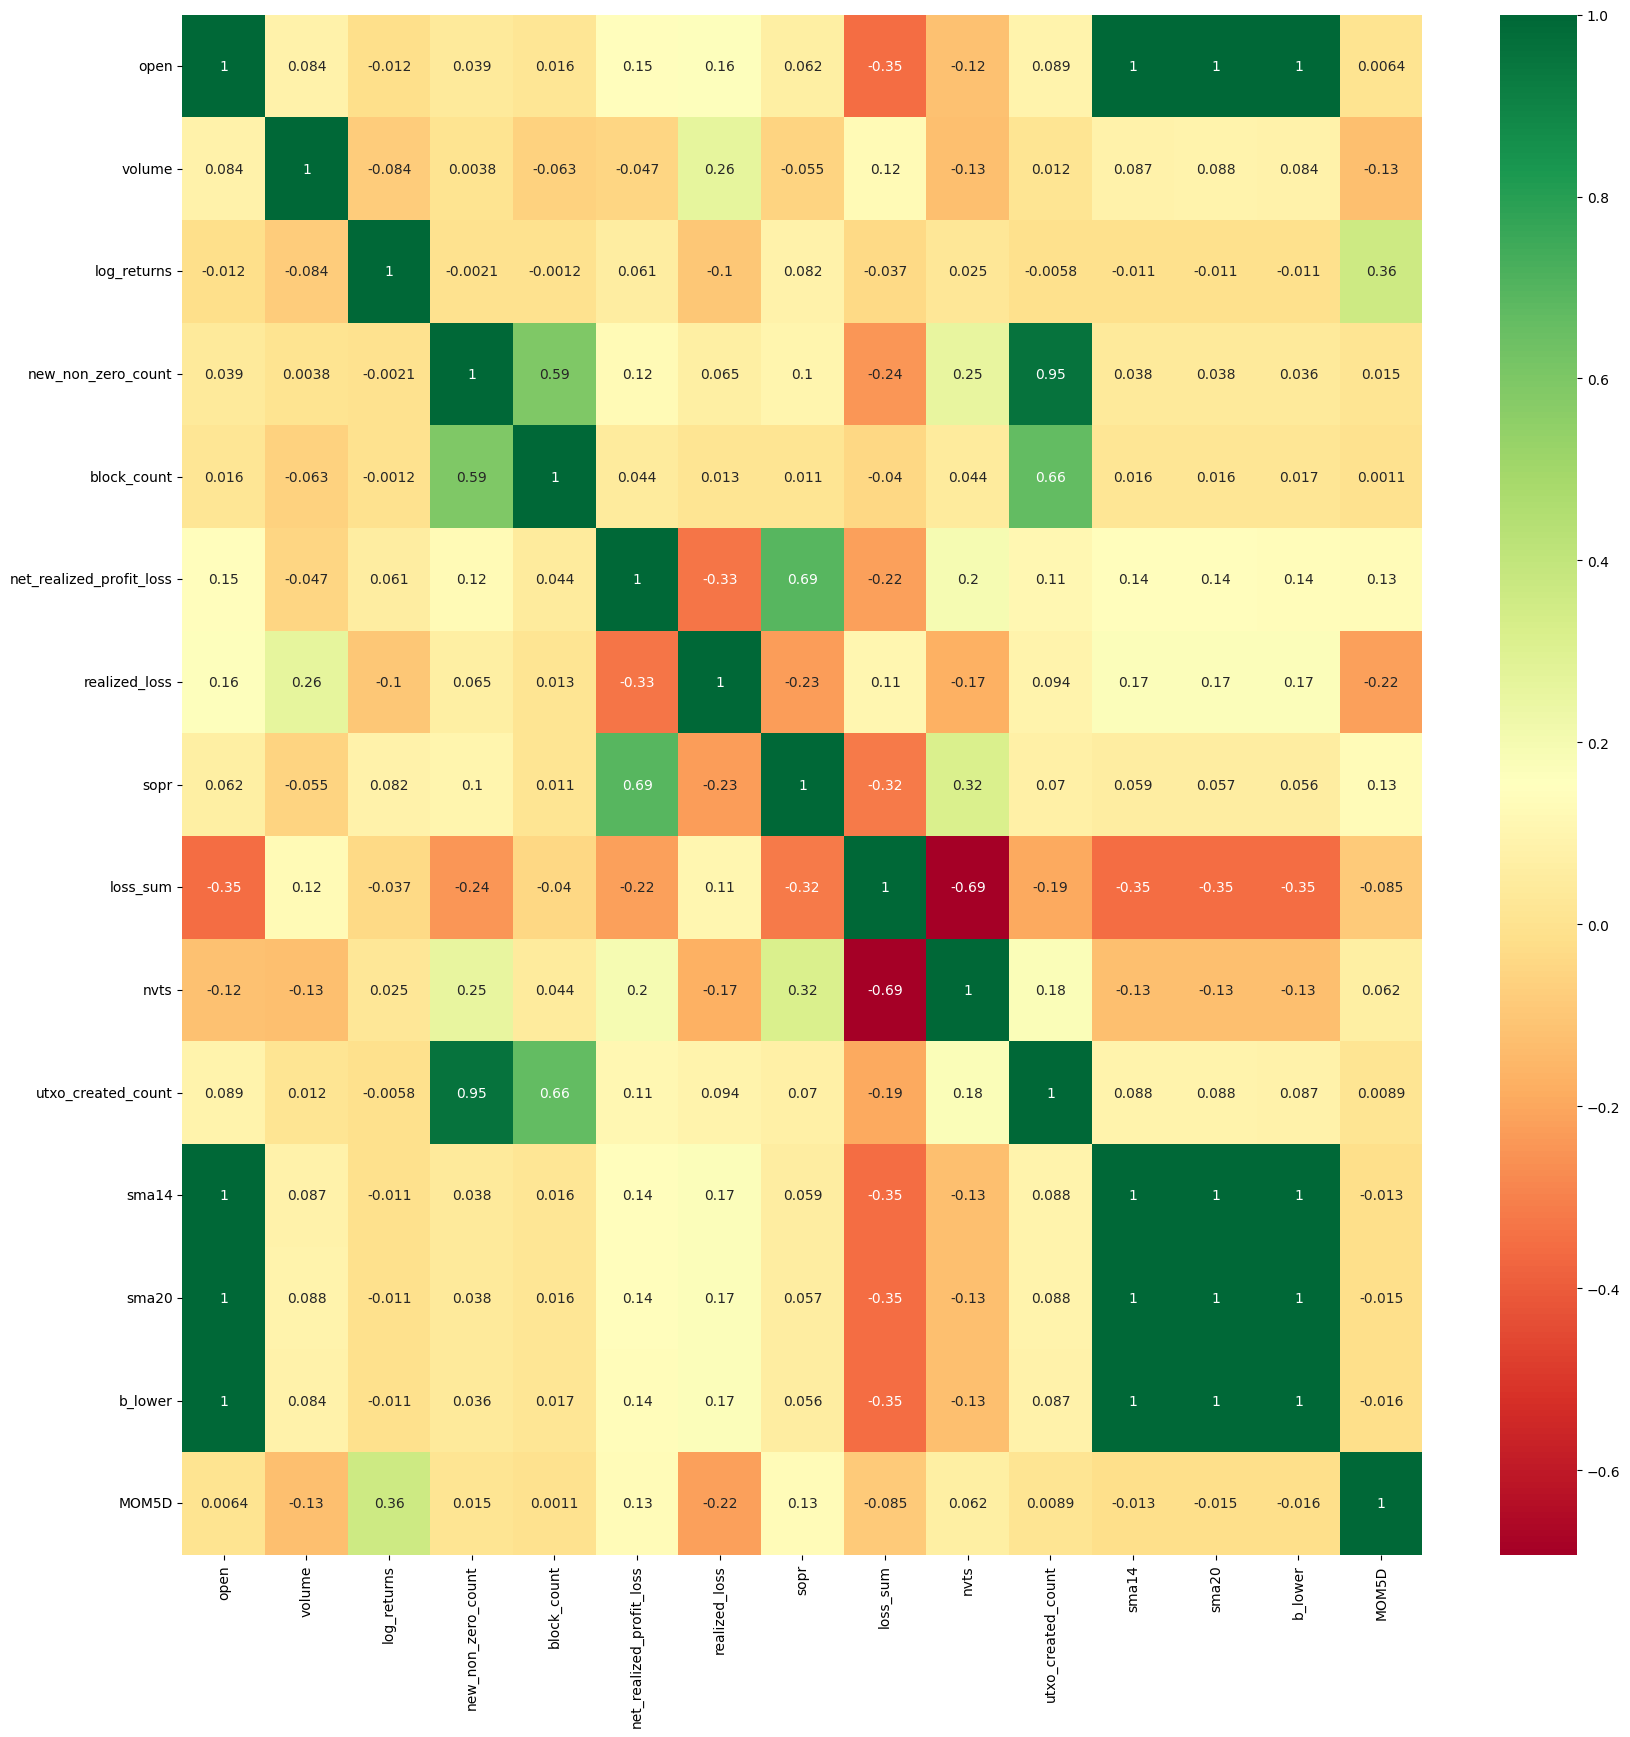

In [28]:
#Correlation Matrix with Heatmap
# We will observe correlations of each features within the dataset
corrmat = X_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))

g = sns.heatmap(X_train[top_corr_features].corr(),annot = True,cmap = "RdYlGn")

## Transform the data splitted before

In [29]:
# Transform the X_test
top_15_features = X_train.columns
X_test = X_test[top_15_features]

In [30]:
# Apply scaling on X_test and X_train
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_train = pd.DataFrame(X_train, columns=top_15_features)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test, columns=top_15_features)
y_test = pd.DataFrame(y_test)

In [32]:
X_train

,open,volume,log_returns,new_non_zero_count,block_count,net_realized_profit_loss,realized_loss,sopr,loss_sum,nvts,utxo_created_count,sma14,sma20,b_lower,MOM5D
0,0.050524,0.009469,0.579152,0.151786,0.333333,0.361572,0.000044,0.205480,0.640234,0.275953,0.216152,0.038921,0.038359,0.048560,0.511641
1,0.050545,0.016852,0.582858,0.178080,0.238095,0.361542,0.000147,0.203230,0.636326,0.277102,0.242180,0.038949,0.038356,0.048652,0.515958
2,0.050703,0.015493,0.582769,0.186983,0.285714,0.361628,0.000040,0.207550,0.616404,0.279407,0.263930,0.038913,0.038389,0.048819,0.516668
3,0.050857,0.016024,0.575972,0.159109,0.142857,0.361539,0.000153,0.203089,0.636581,0.277308,0.178900,0.038903,0.038394,0.048993,0.514379
4,0.050751,0.010400,0.578345,0.190444,0.523810,0.361507,0.000183,0.200937,0.629866,0.277717,0.272797,0.038906,0.038411,0.049207,0.513831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18365,0.595832,0.065274,0.566720,0.138373,0.095238,0.369457,0.003058,0.210615,0.476800,0.104552,0.167155,0.593039,0.591793,0.598602,0.479352
18366,0.592997,0.040854,0.587506,0.141635,0.095238,0.364316,0.004319,0.204691,0.462083,0.106180,0.159624,0.594150,0.592775,0.598947,0.490994
18367,0.595049,0.038106,0.589151,0.448503,0.333333,0.366955,0.002003,0.207359,0.458075,0.107595,0.463541,0.595350,0.593729,0.599272,0.508435
18368,0.597497,0.047074,0.573427,0.278211,0.238095,0.365665,0.003621,0.206682,0.457753,0.107315,0.352098,0.596521,0.594519,0.599487,0.503739


In [33]:
y_train

,Target
0,1
1,1
2,1
3,0
4,0
...,...
18365,0
18366,1
18367,1
18368,0


## Creating Sequence

In [34]:
def create_sequences(X_df, y_df, seq_length=4):
    """
    Generates sequences from a DataFrame (X_df) and aligns with the target (y_df).
    Returns (X_seq, y_seq).
    """
    # Convert DataFrames to numpy arrays for easier manipulation
    X_values = X_df.values  
    y_values = y_df.values  

    # For each valid starting index i, create a sequence: [i : i + seq_length]
    X_seq = np.array([
        X_values[i : i + seq_length] 
        for i in range(len(X_values) - seq_length)
    ])
    
    # The label for that sequence is y at index i + seq_length
    y_seq = y_values[seq_length:]  

    return X_seq, y_seq

In [35]:
# Set sequence length to 24 for 1-day prediction)
sequence_length = 4  # 4 hours data

# Sanity Checking to make sure there’s enough data for sequence creation
if len(X_train) < sequence_length:
    raise ValueError("Not enough training data to generate sequences!")
if len(X_test) < sequence_length:
    raise ValueError("Not enough test data to generate sequences!")

In [36]:
# Generate sequences for training and testing
X_seq_train, y_seq_train = create_sequences(X_train, y_train, seq_length=sequence_length)
X_seq_test, y_seq_test = create_sequences(X_test, y_test, seq_length=sequence_length)

In [37]:
# Check shapes to confirm sequence creation
print(f"X_seq_train shape: {X_seq_train.shape}")
print(f"y_seq_train shape: {y_seq_train.shape}")
print(f"X_seq_test shape: {X_seq_test.shape}")
print(f"y_seq_test shape: {y_seq_test.shape}")

X_seq_train shape: (18366, 4, 15)
y_seq_train shape: (18366, 1)
X_seq_test shape: (7870, 4, 15)
y_seq_test shape: (7870, 1)


## Positional Encoding

In [38]:
def get_positional_encoding(seq_len, feature_dim):
    """
    Generate sinusoidal positional encoding matrix of shape (seq_len, feature_dim)
    """
    pos = np.arange(seq_len)[:, np.newaxis]                     # Shape: (seq_len, 1)
    i = np.arange(feature_dim)[np.newaxis, :]                   # Shape: (1, feature_dim)
    
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / feature_dim)
    angle_rads = pos * angle_rates                              # Shape: (seq_len, feature_dim)

    # Apply sin to even indices (0, 2, 4, ...)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cos to odd indices (1, 3, 5, ...)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return angle_rads  # Shape: (seq_len, feature_dim)

In [39]:
def add_positional_encoding(X_seq):
    """
    Adds positional encoding to input sequences.
    X_seq: numpy array of shape (samples, seq_len, feature_dim)
    """
    seq_len = X_seq.shape[1]
    feature_dim = X_seq.shape[2]
    
    pos_encoding = get_positional_encoding(seq_len, feature_dim)  # Shape: (seq_len, feature_dim)
    X_pos_encoded = X_seq + pos_encoding                          # Broadcasting happens here

    return X_pos_encoded

In [40]:
print(f"X_seq_train shape: {X_seq_train.shape}")
print(f"y_seq_train shape: {y_seq_train.shape}")
print(f"X_seq_test shape: {X_seq_test.shape}")
print(f"y_seq_test shape: {y_seq_test.shape}")

X_seq_train shape: (18366, 4, 15)
y_seq_train shape: (18366, 1)
X_seq_test shape: (7870, 4, 15)
y_seq_test shape: (7870, 1)


In [41]:
# Add positional encoding
X_seq_train_encoded = add_positional_encoding(X_seq_train)
X_seq_test_encoded = add_positional_encoding(X_seq_test)

print(f"X_seq_train_encoded's shape: {X_seq_train_encoded.shape}")
print(f"X_seq_test_encoded's shape: {X_seq_test_encoded.shape}")

X_seq_train_encoded's shape: (18366, 4, 15)
X_seq_test_encoded's shape: (7870, 4, 15)


## Tree-based Model

In [42]:
gauss = GaussianNB()

In [43]:
start_gauss = time.time()
gauss.fit(X_train, y_train)
end_gauss = time.time()
gauss_runtime = end_gauss - start_gauss

# Predict
gauss_preds = gauss.predict(X_test)

print('Runtime:',gauss_runtime)
print("score on test: %.3f"  %gauss.score(X_test, y_test))
print("score on train: %.3f" %gauss.score(X_train, y_train))

Runtime: 0.03207707405090332
score on test: 0.691
score on train: 0.722


C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


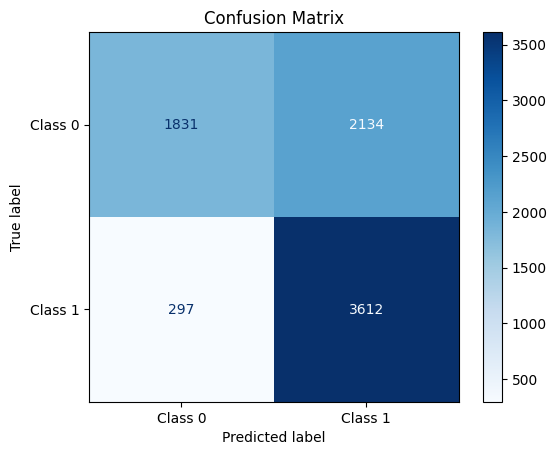

In [44]:
# Generate confusion matrix
cm = confusion_matrix(y_test, gauss_preds.astype(int))

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Modify display labels if needed
cm_display.plot(cmap=plt.cm.Blues)  # You can change the colormap if you like
plt.title('Confusion Matrix')
plt.show()

In [45]:
LR = LogisticRegression(max_iter = 1000)

start_LR = time.time()
LR.fit(X_train, y_train)
end_LR = time.time()
LR_runtime = end_LR - start_LR

# Predict
LR_preds = LR.predict(X_test)

print('Runtime:',LR_runtime)
print("score on test: %.3f" % LR.score(X_test, y_test))
print("score on train: %.3f" % LR.score(X_train, y_train))

Runtime: 0.11373424530029297
score on test: 0.946
score on train: 0.942


C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


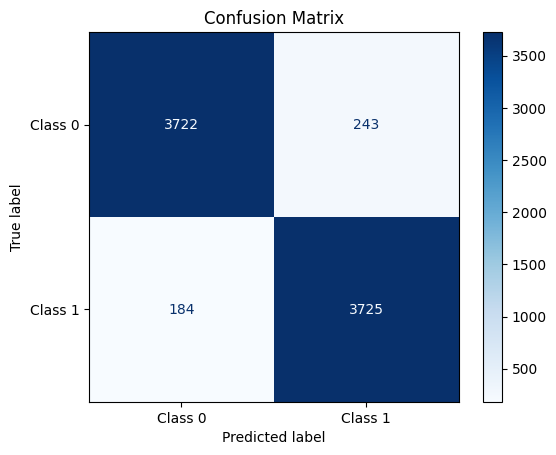

In [46]:
# Generate confusion matrix
cm = confusion_matrix(y_test, LR_preds.astype(int))

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Modify display labels if needed
cm_display.plot(cmap=plt.cm.Blues)  # You can change the colormap if you like
plt.title('Confusion Matrix')
plt.show()

In [47]:
svm = LinearSVC(C = 100)

start_svm = time.time()
svm.fit(X_train, y_train)
end_svm = time.time()
svm_runtime = end_svm - start_svm

# Predict
svm_preds = svm.predict(X_test)

print('Runtime:',svm_runtime)
print("score on test: %.3f" % svm.score(X_test, y_test))
print("score on train: %.3f" % svm.score(X_train, y_train))

C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Runtime: 1.7398829460144043
score on test: 0.994
score on train: 0.994


C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


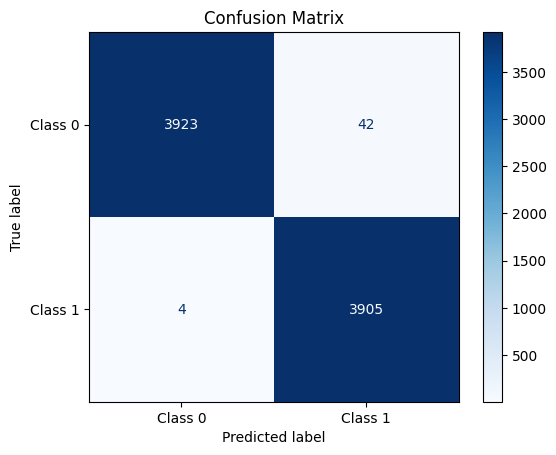

In [48]:
# Generate confusion matrix
cm = confusion_matrix(y_test, svm_preds.astype(int))

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Modify display labels if needed
cm_display.plot(cmap=plt.cm.Blues)  # You can change the colormap if you like
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']})

## Transformer-based Final Alpha Model's Architecture

In [43]:
# TransformerBlock: Implementation of a single transformer block
class TransformerBlock(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=n_features, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.ff = nn.Sequential(
            nn.Linear(n_features, ff_dim),
            nn.LeakyReLU(negative_slope=1.0),
            nn.Linear(ff_dim, ff_dim),
            nn.LeakyReLU(negative_slope=1.0),
            nn.Linear(ff_dim, n_features)
        )
        self.norm2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_rate)


    def forward(self, x):
        # Self-attention and residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward network and residual connection
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

In [44]:
# TransformerClassifier: Simple Transformer-based classifier for sequence inputs
class TransformerClassifier(nn.Module):
    def __init__(self, sequence_length, n_features, num_heads, ff_dim, dropout_rate, num_blocks=4):
        super(TransformerClassifier, self).__init__()

        # Stacking multiple transformer blocks for deeper representation
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(n_features, num_heads, ff_dim, dropout_rate)
            for _ in range(num_blocks)
        ])
        self.attn_pooling = nn.MultiheadAttention(embed_dim=n_features, num_heads=num_heads, batch_first=True)
        
        # self.transformer = TransformerBlock(n_features, num_heads, ff_dim, dropout_rate)
        # self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(n_features, 1)  # Binary classification


    def forward(self, x):
        # x shape: (batch_size, sequence_length, n_features)
        # Pass through all transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer(x)  # Shape: (B, T, F)
        # Apply attention pooling (weighted average)
        attn_output, _ = self.attn_pooling(x, x, x)
        pooled = attn_output.sum(dim=1)  # You can try different aggregation strategies here
        # x = self.transformer(x) # Shape: (B, T, F)
        # x = x.transpose(1,2) # Shape: (B, F, T)
        # x = self.pool(x).squeeze(-1)  # Shape: (B, F)
        # x = x.mean(dim=1)  # Optional: You can also use x.sum(dim=1) or just flatten (B, T*F)
        x = self.fc(pooled) # Shape: (B, 1)
        return x

In [45]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [46]:
class TransformerModel():
    def __init__(self, sequence_length=4, n_features=15, num_heads=3, ff_dim=1024, dropout_rate=0.1,
                 batch_size=32, epochs=20, lr=1e-2, device=None):
        
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = TransformerClassifier(sequence_length, n_features, num_heads, ff_dim, dropout_rate).to(self.device)
        self.model.apply(init_weights)
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.sequence_length = sequence_length
        self.n_features = n_features
        
        self.early_stopping = True
        self.patience = 20
        self.no_improve_epochs = 0
        self.checkpoint_path = "transformer_model_checkpoint.pth"
        self.best_loss = float('inf')

    def train(self, X: np.ndarray, y: np.ndarray) -> None:

        X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

        # Convert numpy arrays to tensors        
        X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(self.device)
        y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).to(self.device)
        X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(self.device)
        y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32).to(self.device)

        # DataLoader for batching
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=self.batch_size)

        # Training phase
        self.model.train()
        train_losses = [] 
        validation_losses = []
        train_accuracies = []
        val_accuracies = []
        
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            correct_train = 0
            total_train = 0
            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

                # Accuracy for training
                preds = (outputs > 0.5).float()
                correct_train += (preds == batch_y).sum().item()
                total_train += batch_y.size(0)

            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            avg_train_acc = correct_train / total_train
            train_accuracies.append(avg_train_acc)

            self.model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    outputs = self.model(batch_x)
                    loss = self.criterion(outputs, batch_y)
                    val_loss += loss.item()

                    # Accuracy for validation
                    preds = (outputs > 0.5).float()
                    correct_val += (preds == batch_y).sum().item()
                    total_val += batch_y.size(0)
            
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            avg_val_acc = correct_val / total_val
            val_accuracies.append(avg_val_acc)

            # Validation Phase
            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"Train Accuracy: {avg_train_acc:.4f}, Val Accuracy: {avg_val_acc:.4f}")

            # Early stopping logic
            # if self.early_stopping:
            #     if avg_val_loss < self.best_loss:
            #         self.best_loss = avg_val_loss
            #         self.no_improve_epochs = 0
            #         torch.save(self.model.state_dict(), self.checkpoint_path)
            #         print("Best model saved.")
            #     else:
            #         self.no_improve_epochs += 1
            #         print(f"No improvement. Patience: {self.no_improve_epochs}/{self.patience}")
            #         if self.no_improve_epochs >= self.patience:
            #             print("Early stopping triggered.")
            #             break
            # else:
            #     torch.save(self.model.state_dict(), f"transformer_epoch_{epoch+1}.pt")

        import matplotlib.pyplot as plt

        # Plot Loss Curve
        fig1, ax1 = plt.subplots()
        ax1.plot(train_losses, label="Train Loss", color='tab:blue')
        ax1.plot(validation_losses, label="Validation Loss", color='tab:orange')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        fig1.suptitle('Training and Validation Loss')
        
        # Plot Accuracy Curve
        fig2, ax2 = plt.subplots()
        ax2.plot(train_accuracies, label="Train Accuracy", color='tab:green', linestyle='--')
        ax2.plot(val_accuracies, label="Validation Accuracy", color='tab:red', linestyle='--')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        fig2.suptitle('Training and Validation Accuracy')
        
        # Show the plots
        plt.show()

    def predict(self, X: np.ndarray) -> pd.Series:
        # Load the best model for prediction
        # self.model.load_state_dict(torch.load("transformer_model_checkpoint.pth"))
        self.model.eval()

        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(X_tensor).view(-1)
            predictions = (outputs > 0.55).float().cpu().numpy()
        
        return predictions


## Training 

In [47]:
# Instantiate the Transformer model
model = TransformerModel()

Epoch 1/20, Train Loss: 0.7348, Val Loss: 0.6946
Train Accuracy: 0.4884, Val Accuracy: 0.4878
Epoch 2/20, Train Loss: 0.6957, Val Loss: 0.6966
Train Accuracy: 0.4887, Val Accuracy: 0.4878
Epoch 3/20, Train Loss: 0.6948, Val Loss: 0.6944
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 4/20, Train Loss: 0.6947, Val Loss: 0.6945
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 5/20, Train Loss: 0.6945, Val Loss: 0.6930
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 6/20, Train Loss: 0.6939, Val Loss: 0.6932
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 7/20, Train Loss: 0.6935, Val Loss: 0.6932
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 8/20, Train Loss: 0.6932, Val Loss: 0.6929
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 9/20, Train Loss: 0.6932, Val Loss: 0.6931
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 10/20, Train Loss: 0.6934, Val Loss: 0.6934
Train Accuracy: 0.4879, Val Accuracy: 0.4878
Epoch 11/20, Train Loss: 0.6931, Val Loss: 0.6933
Train Acc

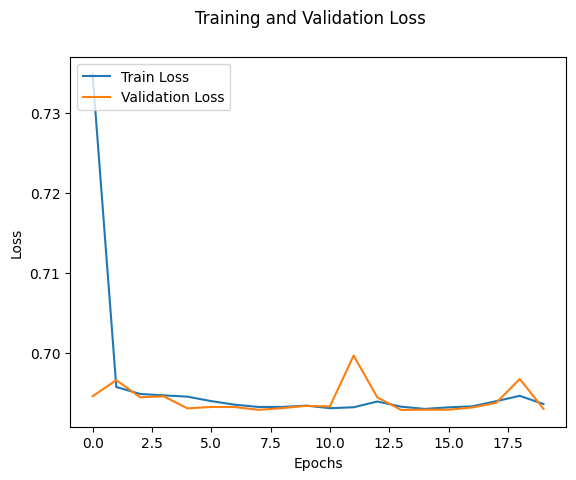

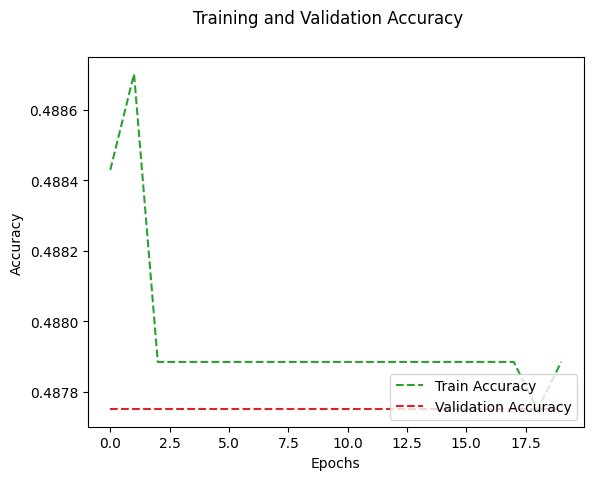

NameError: name 'start_transformer' is not defined

In [48]:
# start_transformer = time.time()
model.train(X_seq_train_encoded, y_seq_train)
end_transformer = time.time()
transformer_runtime = end_transformer - start_transformer

print('Runtime:',transformer_runtime)

In [50]:
from xgboost import XGBClassifier

# Initialize the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

start_xgb = time.time()
xgb.fit(X_train, y_train)
end_xgb = time.time()
xgb_runtime = end_xgb - start_xgb

# Predict
xgb_preds = xgb.predict(X_test)

print("Runtime: ", xgb_runtime)
print("score on test: %.3f" % xgb.score(X_test, y_test))
print("score on train: %.3f" % xgb.score(X_train, y_train))

Runtime:  0.1377239227294922
score on test: 0.998
score on train: 1.000


C:\Users\BoonPing\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, xgb_preds.astype(int))

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Modify display labels if needed
cm_display.plot(cmap=plt.cm.Blues)  # You can change the colormap if you like
plt.title('Confusion Matrix')
plt.show()

## Evaluation

In [ ]:
preds = model.predict(X_seq_test_encoded)
acc = accuracy_score(y_seq_test, preds.astype(int))
print(f"Transformer Accuracy: {acc:.4f}\n")

# Generate confusion matrix
cm = confusion_matrix(y_seq_test, preds.astype(int))

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Modify display labels if needed
cm_display.plot(cmap=plt.cm.Blues)  # You can change the colormap if you like
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cm

In [ ]:
print("Sample outputs (raw):", y_seq_test[:10])
print("Sample outputs (sigmoid):", torch.sigmoid(torch.tensor(y_seq_test[:10], dtype=torch.float)))
print("Predictions:", preds[:10])
print("Ground truth:", y_seq_test[:10])


## Debugging

y_small: [[0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]]
Unique labels in y_small: [0 1]
raw outputs:  tensor([0.0816, 0.0825], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.5204, 0.5206], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([0.0859, 0.0860], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.5215, 0.5215], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([0.0881, 0.0876], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.5220, 0.5219], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([0.0898, 0.0905], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.5224, 0.5226], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([0.0901, 0.0907], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.5225, 0.5226], grad_fn=<SigmoidBackward0>)

Epoch 1, Loss: 0.6950, Accuracy: 0.5000
raw outputs:  tensor([0.0881, 0.0875], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.5220, 0.5219], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([0.0883, 0.0873], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.

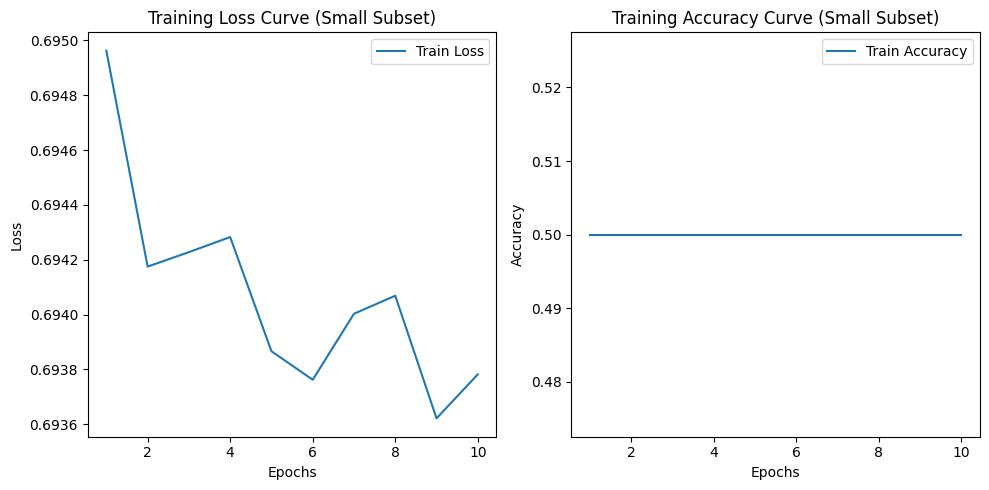

In [49]:
# 1. Small subset
X_small = X_seq_train_encoded[:10]
y_small = y_seq_train[:10]

print("y_small:", y_small)
print("Unique labels in y_small:", np.unique(y_small))  # ⬅️ check for both 0 and 1

# 2. TensorDataset + DataLoader
small_dataset = TensorDataset(torch.tensor(X_small, dtype=torch.float32),
                              torch.tensor(y_small, dtype=torch.float32))
small_loader = DataLoader(small_dataset, batch_size=2, shuffle=True)

# 3. Define optimizer & loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.model.parameters(), lr=1e-3)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []

# 4. Train
for epoch in range(10):
    model.model.train()
    total_loss = 0
    correct = 0
    for batch_x, batch_y in small_loader:
        optimizer.zero_grad()

        # ---- Forward pass
        outputs = model.model(batch_x).squeeze()  # Shape: (B,)
        print("raw outputs: ", outputs)
        print("outputs: ", torch.sigmoid(outputs))

        # ---- Loss & backward
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == batch_y.squeeze()).sum().item()

    avg_loss = total_loss / len(small_loader)
    accuracy = correct / len(small_dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"\nEpoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label="Train Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve (Small Subset)')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label="Train Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve (Small Subset)')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
from sklearn.datasets import load_breast_cancer

# Load and preprocess
data = load_breast_cancer()
X = data.data
y = data.target


In [52]:
X.shape

(569, 30)

In [59]:
y.shape

(569,)

In [53]:
y.shape

(569,)

In [54]:
X_seq_train_encoded.shape

(18366, 4, 15)

In [56]:
y_seq_train.shape

(18366, 1)

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_dup = np.tile(X_scaled, (1, 2))[:, :60]  # shape (569, 60)

# Reshape to (batch_size, 4, 15)
X_reshaped = X_dup.reshape(-1, 4, 15)

# 3. Reshape y to (batch_size, 1)
y_reshaped = y.reshape(-1, 1)

# ✅ Final shapes
print("X_reshaped shape:", X_reshaped.shape)  # (569, 4, 15)
print("y_reshaped shape:", y_reshaped.shape)  # (569, 1)

X_reshaped shape: (569, 4, 15)
y_reshaped shape: (569, 1)


y_small: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Unique labels in y_small: [0]
raw outputs:  tensor([-7.7480, -7.3310], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.0004, 0.0007], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([-6.9815, -7.5630], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.0009, 0.0005], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([-7.6749, -7.8607], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.0005, 0.0004], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([-7.1938, -4.7197], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.0008, 0.0088], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([-7.9726, -8.3207], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.0003, 0.0002], grad_fn=<SigmoidBackward0>)

Epoch 1, Loss: 0.0014, Accuracy: 1.0000
raw outputs:  tensor([-8.6969, -8.4513], grad_fn=<SqueezeBackward0>)
outputs:  tensor([0.0002, 0.0002], grad_fn=<SigmoidBackward0>)
raw outputs:  tensor([-8.8529, -8.6779], grad_fn=<SqueezeBackward0>)
outputs:

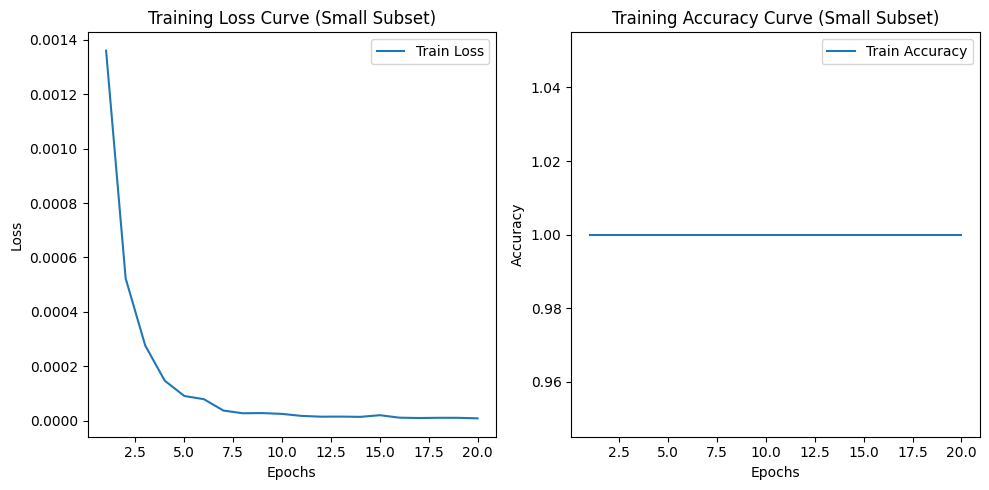

In [64]:
# 1. Small subset
X_small = X_reshaped[:10]
y_small = y_reshaped[:10]

print("y_small:", y_small)
print("Unique labels in y_small:", np.unique(y_small))  # ⬅️ check for both 0 and 1

# 2. TensorDataset + DataLoader
small_dataset = TensorDataset(torch.tensor(X_small, dtype=torch.float32),
                              torch.tensor(y_small, dtype=torch.float32))
small_loader = DataLoader(small_dataset, batch_size=2, shuffle=True)

# 3. Define optimizer & loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.model.parameters(), lr=1e-3)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []

# 4. Train
for epoch in range(20):
    model.model.train()
    total_loss = 0
    correct = 0
    for batch_x, batch_y in small_loader:
        optimizer.zero_grad()

        # ---- Forward pass
        outputs = model.model(batch_x).squeeze()  # Shape: (B,)
        print("raw outputs: ", outputs)
        print("outputs: ", torch.sigmoid(outputs))

        # ---- Loss & backward
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == batch_y.squeeze()).sum().item()

    avg_loss = total_loss / len(small_loader)
    accuracy = correct / len(small_dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"\nEpoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses, label="Train Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve (Small Subset)')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), train_accuracies, label="Train Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve (Small Subset)')
plt.legend()

plt.tight_layout()
plt.show()

## Save the model